# Predicting Spotify Top 100 Hits: A Machine Learning Approach

### Introduction
In this project, we aim to develop a machine learning model to predict the success of songs on Spotify, specifically focusing on whether they will appear in the Top 100 Spotify chart. By analyzing various features of songs, we hope to provide insights that can help music labels and producers make informed decisions about their investments.




## 1 Data Loading and Set up



### 1.1 Importing Libraries


In [ ]:
# Install library
# !pip install category_encoders
# !pip install mlflow
# !pip install -U scikit-learn imbalanced-learn xgboost mlflow
# !pip install pyngrok --quiet

In [2]:
# Importing all the require libraries
import mlflow
import mlflow.sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

import xgboost as xgb

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

# For local jupyter notebook
data_dir_path='../'


# Mount google drive to project
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir_path='/content/drive/My Drive/ITI105_Project/'

### 1.2 Loading the Datasets


#### Data Pre-Preparation Overview

In this project, we prepared our dataset by focusing on relevant time periods and enhancing our data with additional features.

The data imported has undergone several pre-processing steps, handled by a separate Python script file named `01_query_audio_features_and_genre.py`.

The data imported has undergone several pre-processing steps, each handled by different Python script files:

* `01_query_audio_features_and_genre.py`: Queries the Spotify API to retrieve genres and audio features for the first 1000 playlists from the Spotify Million Playlist Dataset.
* `02_filter_unique_tracks.py`: Filters songs that were part of the Top 100 charts between 2016 and 2019 from the playlist data and matches songs based on their release dates to our target period.
* `03_flatten_json_to_csv.py`: Converts nested JSON objects from the Spotify API responses into a flattened CSV format for easier access and processing.
* `04_top_100_query_features.py`: Queries the audio features for the Top 100 songs from the Spotify API to ensure consistency and completeness of the audio feature data. This script also removes outliers from the Top 100 dataset.


These steps ensure relevant dataset for training our machine learning model.

#### Dataset Description

In this machine learning project, we will be using datasets from two sources:

*  `cleaned_unique_tracks_2015_2019_flattened.csv`: This dataset includes tracks from the first 1000 playlists of the Spotify Million Playlist Dataset, enriched with genres and audio features. The tracks are filtered to include only those released between 2015 and 2019.

*  `Final_Updated_Spotify_Top_100.csv`: This dataset contains details of songs that appeared in the Spotify Top 100 charts between 2016 and 2019, including metadata such as song titles,  artists, genres, release dates and audio features.

These datasets provide a comprehensive view of both popular and non-popular songs, allowing us to develop a robust predictive model.

In [4]:
# Edit file path
file_path = 'dataset/'

spotify_non_top100_songs_df = pd.read_csv(data_dir_path + file_path + 'cleaned_unique_tracks_2015_2019_flattened.csv')
spotify_top100_df = pd.read_csv(data_dir_path + file_path + 'Final_Updated_Spotify_Top_100.csv')

In [6]:
spotify_non_top100_songs_df.head().T
spotify_top100_df.head().T

,0,1,2,3,4
title,Hurts So Good,Gold,Easier,i'm so tired...,Options
artist,Astrid S,Kiiara,5 Seconds of Summer,Lauv,NSG
top genre,alt z,alt z,boy band,dance pop,afro dancehall
year released,2016,2015,2019,2019,2018
added,2020‑06‑08,2020‑06‑08,2020‑06‑22,2020‑06‑22,2020‑08‑20
bpm,120,113,176,102,102
nrgy,0.737,0.696,0.399,0.806,0.798
dnce,0.785,0.629,0.547,0.736,0.47
dB,-5.306,-5.572,-9.808,-7.47,-5.504
live,0.108,0.0554,0.132,0.162,0.291


## 2 Data Splitting
We split the data into training and testing sets to ensure that we can perform exploratory data analysis, data cleaning, and feature engineering on the training set separately. This helps to avoid data leakage. We split the `spotify_top100_df` based on the `top_year`, using data from 2016-2018 for training and 2019 for testing. We also ensure that no songs released after 2018 are included in the training set by checking the `album_release_date` in `spotify_non_top100_songs_df`.

### Standardize Column Names
Based on the previous printout, we observed that the column names in `spotify_top100_df` and `spotify_non_top100_songs_df` do not match. Therefore, we need to adjust the columns for Spotify Top 100 to match the non-top 100 dataset to facilitate merging. Additionally, to join the datasets, we will indicate whether the song is a top 100 song or not, to simulate the binary classification task.


In [9]:
# Standardize Column Names
spotify_top100_df.rename(columns={
    'title': 'track_name',
    'artist': 'artist_name',
    'top genre': 'artist_genres',
    'year released': 'album_release_date',
    'bpm': 'audio_features_tempo',
    'nrgy': 'audio_features_energy',
    'dnce': 'audio_features_danceability',
    'dB': 'audio_features_loudness',
    'live': 'audio_features_liveness',
    'val': 'audio_features_valence',
    'dur': 'duration_ms',
    'acous': 'audio_features_acousticness',
    'spch': 'audio_features_speechiness',
    'pop': 'artist_popularity',
    'top year': 'top_year',
    'artist type': 'artist_type'
}, inplace=True)


# Convert 'album_released_date' to datetime
spotify_top100_df['album_release_date'] = pd.to_datetime(spotify_top100_df['album_release_date'], format='%Y')
spotify_non_top100_songs_df['album_release_date'] = pd.to_datetime(spotify_non_top100_songs_df['album_release_date'])


# Split the train test data by using top y|ear
train_top100 = spotify_top100_df[(spotify_top100_df['top_year'] >= 2016) & (spotify_top100_df['top_year'] <= 2018)]
test_top100_2019 = spotify_top100_df[spotify_top100_df['top_year'] == 2019]

# Be sure that songs released after 2018 are not in the training set (top songs for 2016 - 2019)
print(spotify_non_top100_songs_df[spotify_non_top100_songs_df['album_release_date'].dt.year < 2019])
print(spotify_non_top100_songs_df[spotify_non_top100_songs_df['album_release_date'].dt.year >= 2019])

# Since there are no songs in spotify_non_top100_songs_df that release after 2018, we can split the train_non_top_100 into a training and testing set using the same ratio as the top 100 songs dataset.
ratio = len(train_top100) / (len(train_top100) + len(test_top100_2019))
train_non_top_100, test_non_top_100 = train_test_split(spotify_non_top100_songs_df, test_size=(1-ratio), stratify=spotify_non_top100_songs_df['album_release_date'].dt.year, random_state=42)

# Add a target variable
train_top100['isTop100'] = 1
test_top100_2019['isTop100'] = 1
train_non_top_100['isTop100'] = 0
test_non_top_100['isTop100'] = 0

# Combine the datasets
train_set = pd.concat([train_top100, train_non_top_100], ignore_index=True)
test_set = pd.concat([test_top100_2019, test_non_top_100], ignore_index=True)

          artist_name                                     track_name  \
0               3OH!3                  STARSTRUKK (feat. Katy Perry)   
1      Daniel Tidwell                                  Pokémon Theme   
2      Daniel Tidwell     Concerning Hobbits (The Lord of the Rings)   
3      Daniel Tidwell  The Blood of Cuchulainn (The Boondock Saints)   
4      Daniel Tidwell       He's a Pirate (Pirates of the Caribbean)   
...               ...                                            ...   
10031           Jon D                                   I Don't Know   
10032       Big Words                                     The Answer   
10033    Allan Rayman                                          25.22   
10034       Jon Jason                                   Good Feeling   
10035        Grizfolk   Cosmic Angel - Acoustic From Capitol Studios   

       duration_ms                          album_name  \
0            70294                    Versus Hollywood   
1            65306 

## 3 Exploratory Data Analysis (EDA)


### 3.1 Data Quality Check
Assess the quality of the data, looking for missing values, duplicates, and inconsistencies.


In [11]:
#  Check the null data
print('train_set.isnull\n')
print(train_set.isnull().sum())

print('\test_set\n')
print(test_set.isnull().sum())


train_set.isnull

track_name                            0
artist_name                           0
artist_genres                       624
album_release_date                    0
added                              7545
audio_features_tempo                  0
audio_features_energy                 0
audio_features_danceability           0
audio_features_loudness               0
audio_features_liveness               0
audio_features_valence                0
duration_ms                           0
audio_features_acousticness           0
audio_features_speechiness            0
artist_popularity                    26
top_year                           7545
artist_type                        7545
isTop100                              0
album_name                          300
artist_followers                    326
album_type                          300
audio_features_key                  300
audio_features_mode                 300
audio_features_instrumentalness     300
audio_features_time_si

Given a dataset describing various aspects of songs on Spotify, we are predicting whether a song will be in the top 100 on Spotify.

**Target Variable** - isTop100 - a binary value indicating if the song is in the top 100 (1) or not (0).

**Features**

|Feature|Description|
|:--:|:---|
|track_name|Name of the track|
|artist_name|Name of the artist|
|artist_genres|Genres associated with the artist|
|album_release_date|Release date of the album|
|added|Date the track was added to the dataset|
|audio_features_tempo|The overall estimated tempo of a track in beats per minute (BPM)|
|audio_features_energy|A measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity|
|audio_features_danceability|A measure from 0.0 to 1.0 representing how suitable a track is for dancing|
|audio_features_loudness|The overall loudness of a track in decibels (dB)|
|audio_features_liveness|A measure from 0.0 to 1.0 representing the presence of an audience in the recording|
|audio_features_valence|A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track|
|duration_ms|Duration of the track in milliseconds|
|audio_features_acousticness|A measure from 0.0 to 1.0 representing the confidence of whether the track is acoustic|
|audio_features_speechiness|A measure from 0.0 to 1.0 representing the presence of spoken words in a track|
|artist_popularity|Popularity of the artist|
|top_year|Year the track was in the top 100|
|artist_type|Type of artist (e.g., solo, band)|
|album_name|Name of the album|
|artist_followers|Number of followers of the artist|
|album_type|Type of the album (e.g., single, album)|
|audio_features_key|The key the track is in|
|audio_features_mode|Mode of the track (0 = minor, 1 = major)|
|audio_features_instrumentalness|A measure from 0.0 to 1.0 predicting whether a track contains no vocals|
|audio_features_time_signature|An estimated time signature ranging from 3 to 7|

In [13]:
# Declare variables
feature_names = ['track_name', 'artist_name', 'artist_genres', 'album_release_date', 'added',
                 'audio_features_tempo', 'audio_features_energy', 'audio_features_danceability',
                 'audio_features_loudness', 'audio_features_liveness', 'audio_features_valence',
                 'duration_ms', 'audio_features_acousticness', 'audio_features_speechiness',
                 'artist_popularity', 'top_year', 'artist_type', 'isTop100', 'album_name',
                 'artist_followers', 'album_type', 'audio_features_key', 'audio_features_mode',
                 'audio_features_instrumentalness', 'audio_features_time_signature']


continuous_vars = ['audio_features_tempo', 'audio_features_energy', 'audio_features_danceability',
                   'audio_features_loudness', 'audio_features_liveness', 'audio_features_valence',
                   'duration_ms', 'audio_features_acousticness', 'audio_features_speechiness',
                   'artist_popularity', 'top_year', 'artist_followers', 'audio_features_key',
                   'audio_features_instrumentalness']


categorical_vars = ['track_name', 'artist_name', 'artist_genres', 'album_release_date', 'added',
                    'artist_type', 'album_name', 'album_type', 'audio_features_mode', 'audio_features_time_signature']



### 3.2 Descriptive Statistics
For descriptive statistics, it is important to explore both the training and test sets separately to avoid data leakage. Combining them for initial descriptive statistics might give a false impression of the data distribution as the test set should not influence any decisions based on descriptive statistics. However, for the initial exploration to get a sense of the entire dataset, we can combine them temporarily.

In [16]:
data = pd.concat([train_set, test_set], ignore_index=True)

# Initial exploration (basic checks)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10435 entries, 0 to 10434
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   track_name                       10435 non-null  object        
 1   artist_name                      10435 non-null  object        
 2   artist_genres                    9599 non-null   object        
 3   album_release_date               10435 non-null  datetime64[ns]
 4   added                            399 non-null    object        
 5   audio_features_tempo             10435 non-null  float64       
 6   audio_features_energy            10435 non-null  float64       
 7   audio_features_danceability      10435 non-null  float64       
 8   audio_features_loudness          10435 non-null  float64       
 9   audio_features_liveness          10435 non-null  float64       
 10  audio_features_valence           10435 non-null  float64  

,album_release_date,audio_features_tempo,audio_features_energy,audio_features_danceability,audio_features_loudness,audio_features_liveness,audio_features_valence,duration_ms,audio_features_acousticness,audio_features_speechiness,artist_popularity,top_year,isTop100,artist_followers,audio_features_key,audio_features_mode,audio_features_instrumentalness,audio_features_time_signature
count,10435,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.000000,10435.00000,10401.000000,399.000000,10435.000000,1.000200e+04,10036.000000,10036.000000,10036.000000,10036.000000
mean,2016-05-28 08:51:58.735026432,121.381170,0.642715,0.620519,-6.850298,0.186316,0.447372,223567.111356,0.230295,0.10937,57.241804,2017.496241,0.038237,6.147971e+06,5.209645,0.615584,0.049563,3.939418
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2016.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2015-09-18 00:00:00,99.969000,0.514000,0.519000,-8.164000,0.096800,0.266000,192175.500000,0.024200,0.03840,44.000000,2016.500000,0.000000,1.150170e+05,2.000000,0.000000,0.000000,4.000000
50%,2016-05-20 00:00:00,120.606000,0.662000,0.630000,-6.343000,0.125000,0.427000,216391.000000,0.119000,0.05950,60.000000,2017.000000,0.000000,8.074630e+05,5.000000,1.000000,0.000003,4.000000
75%,2017-02-03 00:00:00,139.962500,0.797000,0.735000,-4.872500,0.231000,0.611000,245380.500000,0.356000,0.13400,74.000000,2018.000000,0.000000,5.330874e+06,8.000000,1.000000,0.000728,4.000000
max,2019-01-01 00:00:00,214.117000,0.999000,0.981000,2.574000,0.986000,0.985000,814733.000000,0.996000,0.87400,94.000000,2019.000000,1.000000,1.145027e+08,11.000000,1.000000,0.995000,5.000000
std,NaN,28.172541,0.199147,0.154027,3.066809,0.148201,0.227377,56586.819744,0.263819,0.10984,21.248599,1.118309,0.191776,1.471849e+07,3.602619,0.486481,0.172172,0.349127


### 3.3 Data Visualization


#### Data Visualization Methods
Using plots (e.g., histograms, scatter plots, box plots) to visualize the data and identify patterns, trends, and outliers for both train set and test set.


`Histograms` - provide a visual representation of the distribution of continuous variables in the training set. By examining these plots, we can identify the central tendency, spread, skewness, and potential outliers in each feature.

`Boxplots` - offer a summary of the distribution of continuous variables, highlighting the median, quartiles, and potential outliers. This helps us understand the variability and detect any extreme values in the training data.

`Heatmap` - correlation heatmap shows the correlation coefficients between continuous variables. It helps identify highly correlated features, which may need to be addressed to avoid multicollinearity issues during model training.

In [18]:
# Plotting histograms for continuous variables
def plot_histograms(df, variables, title, rows = 4, cols = 4):
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    fig.suptitle(title, fontsize=16)
    for i, var in enumerate(variables):
        ax = axes[i // cols, i % cols]
        sns.histplot(df[var], kde=True, ax=ax)
        ax.set_title(f'{var} Distribution')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Plotting boxplots for continuous variables
def plot_boxplots(df, variables, title, rows = 4, cols = 4):
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    fig.suptitle(title, fontsize=16)
    for i, var in enumerate(variables):
        ax = axes[i // cols, i % cols]
        sns.boxplot(x=df[var], ax=ax)
        ax.set_title(f'{var} Boxplot')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Correlation heatmap
def plot_correlation_heatmap(df, variables, title):
    corr = df[variables].corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


#### Data Visualization for Training set

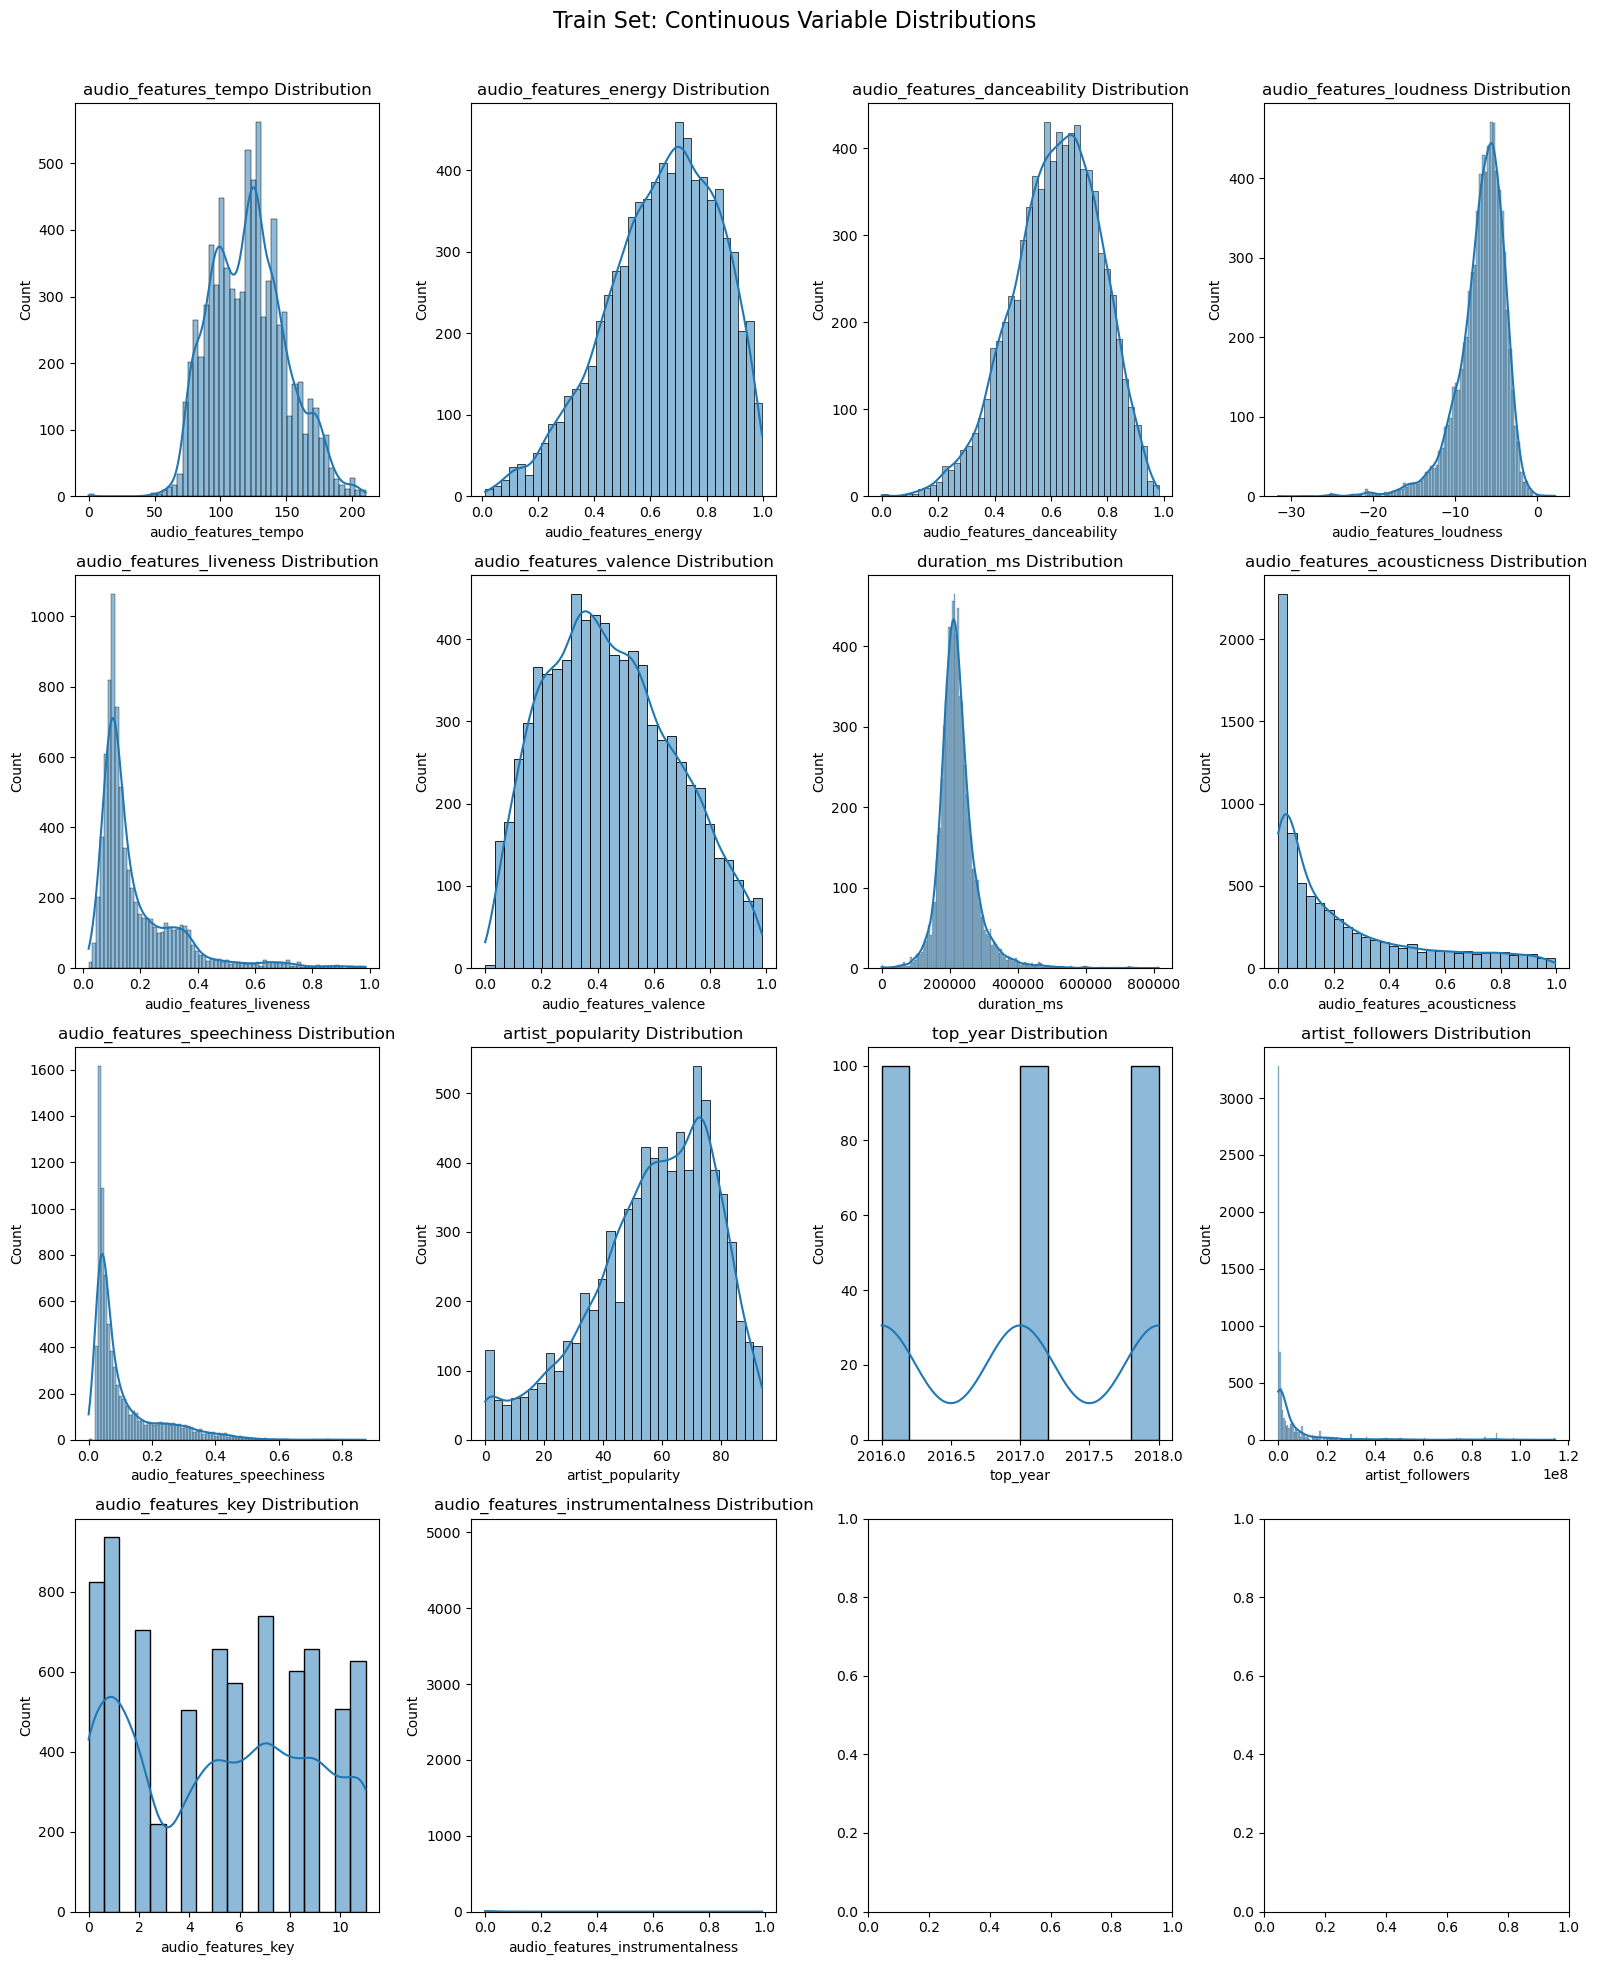

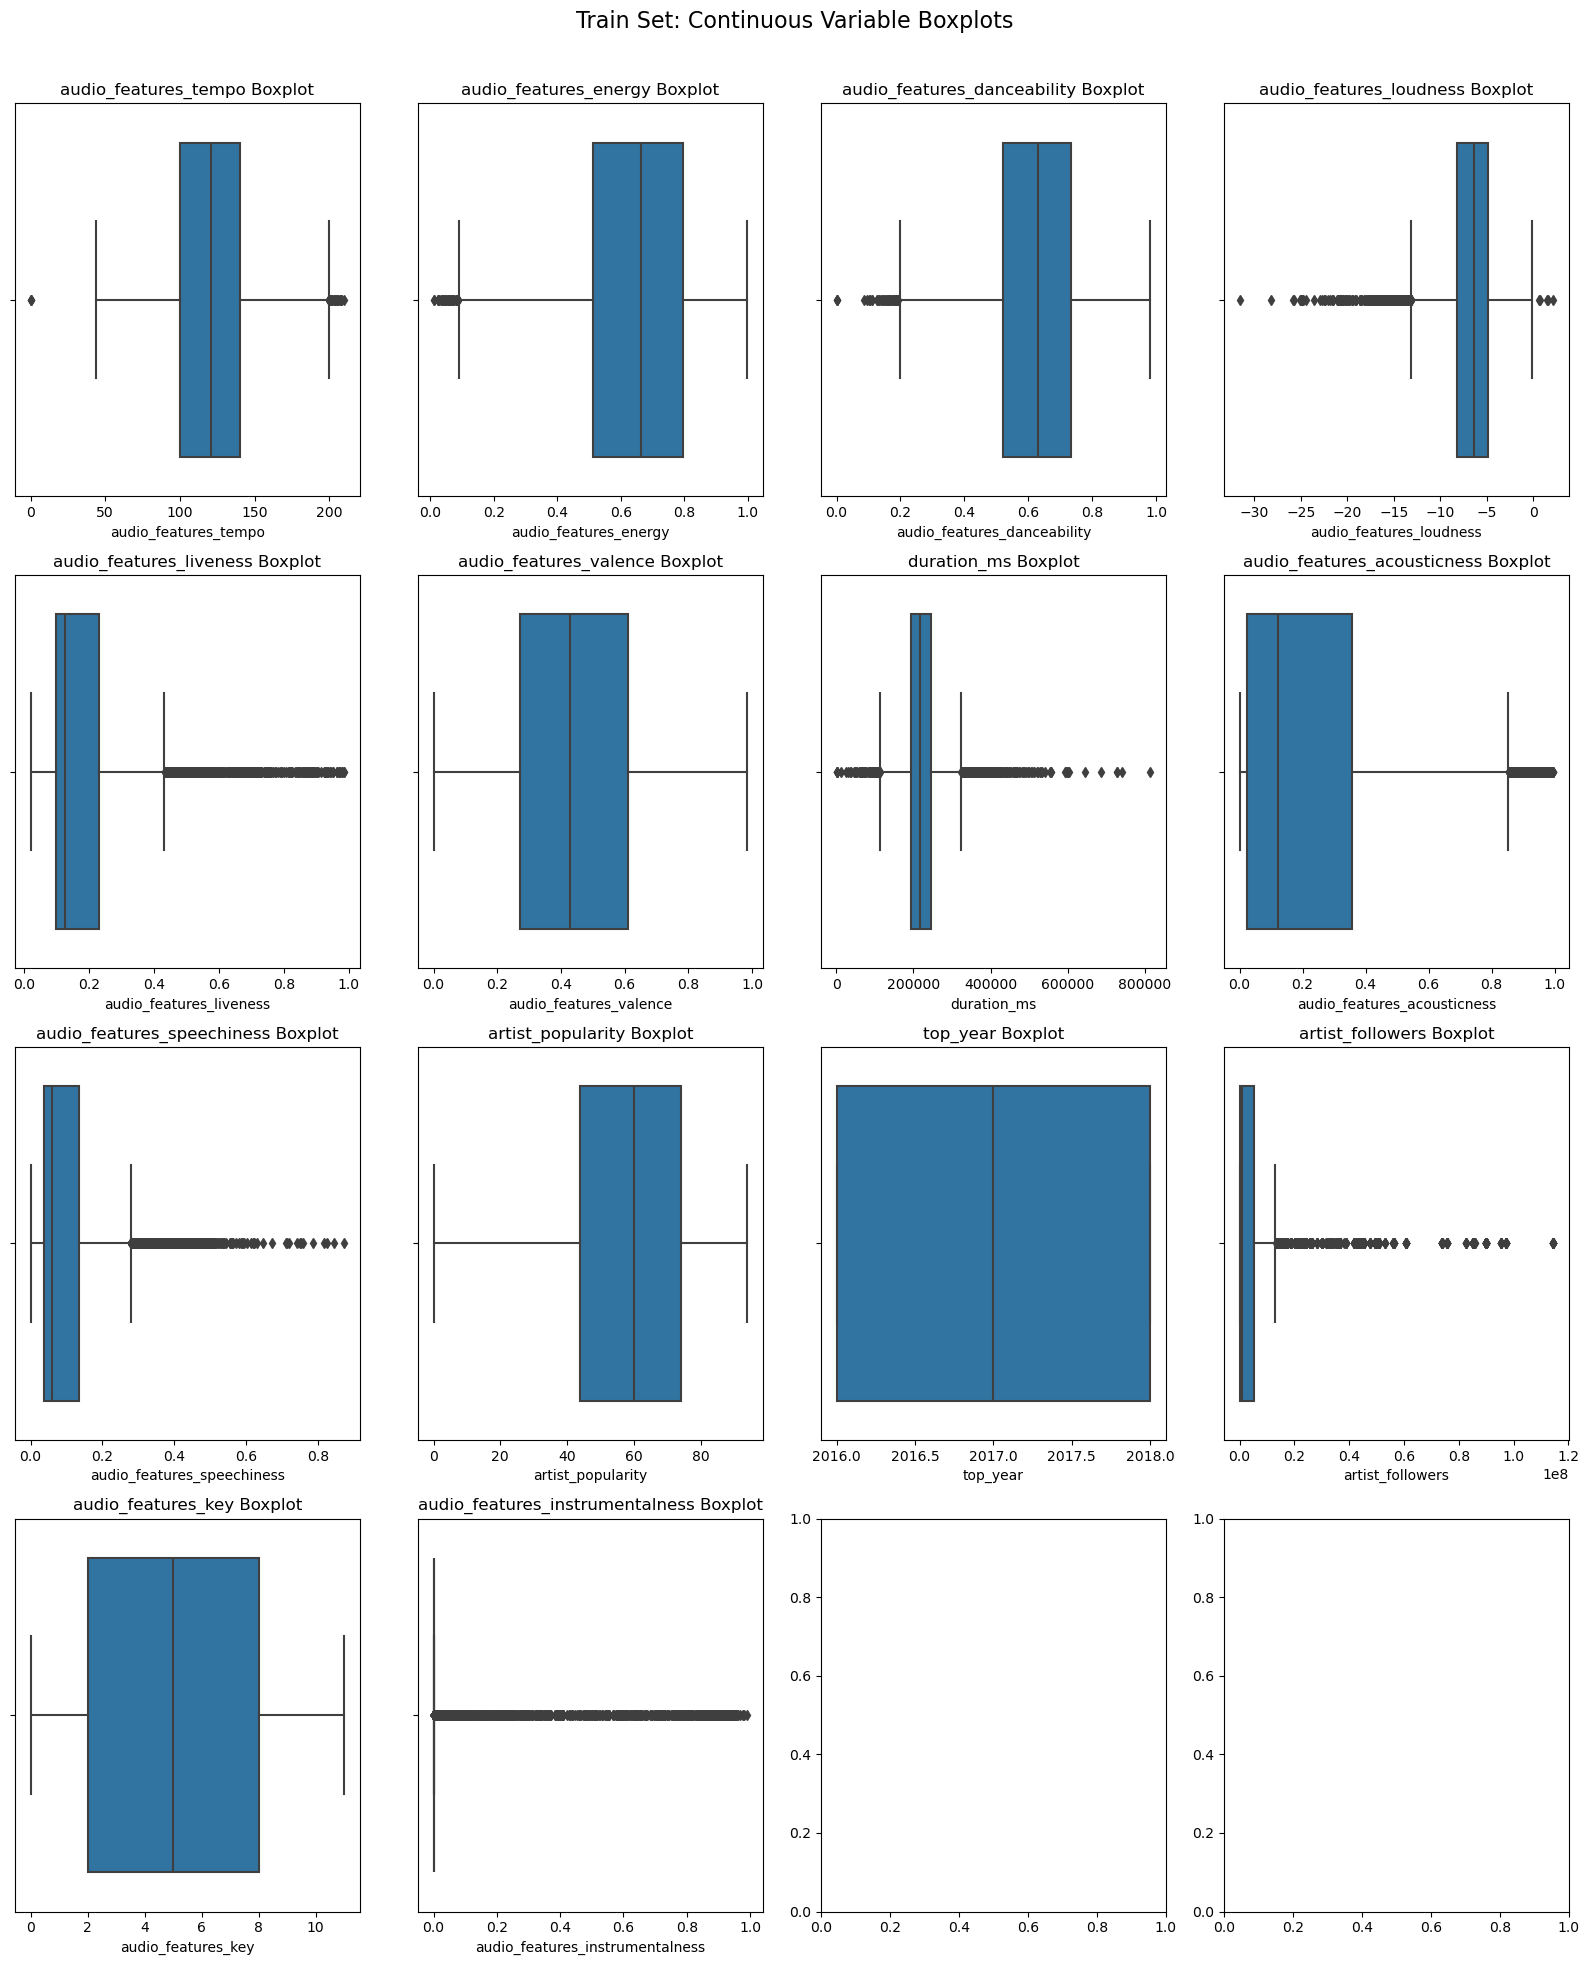

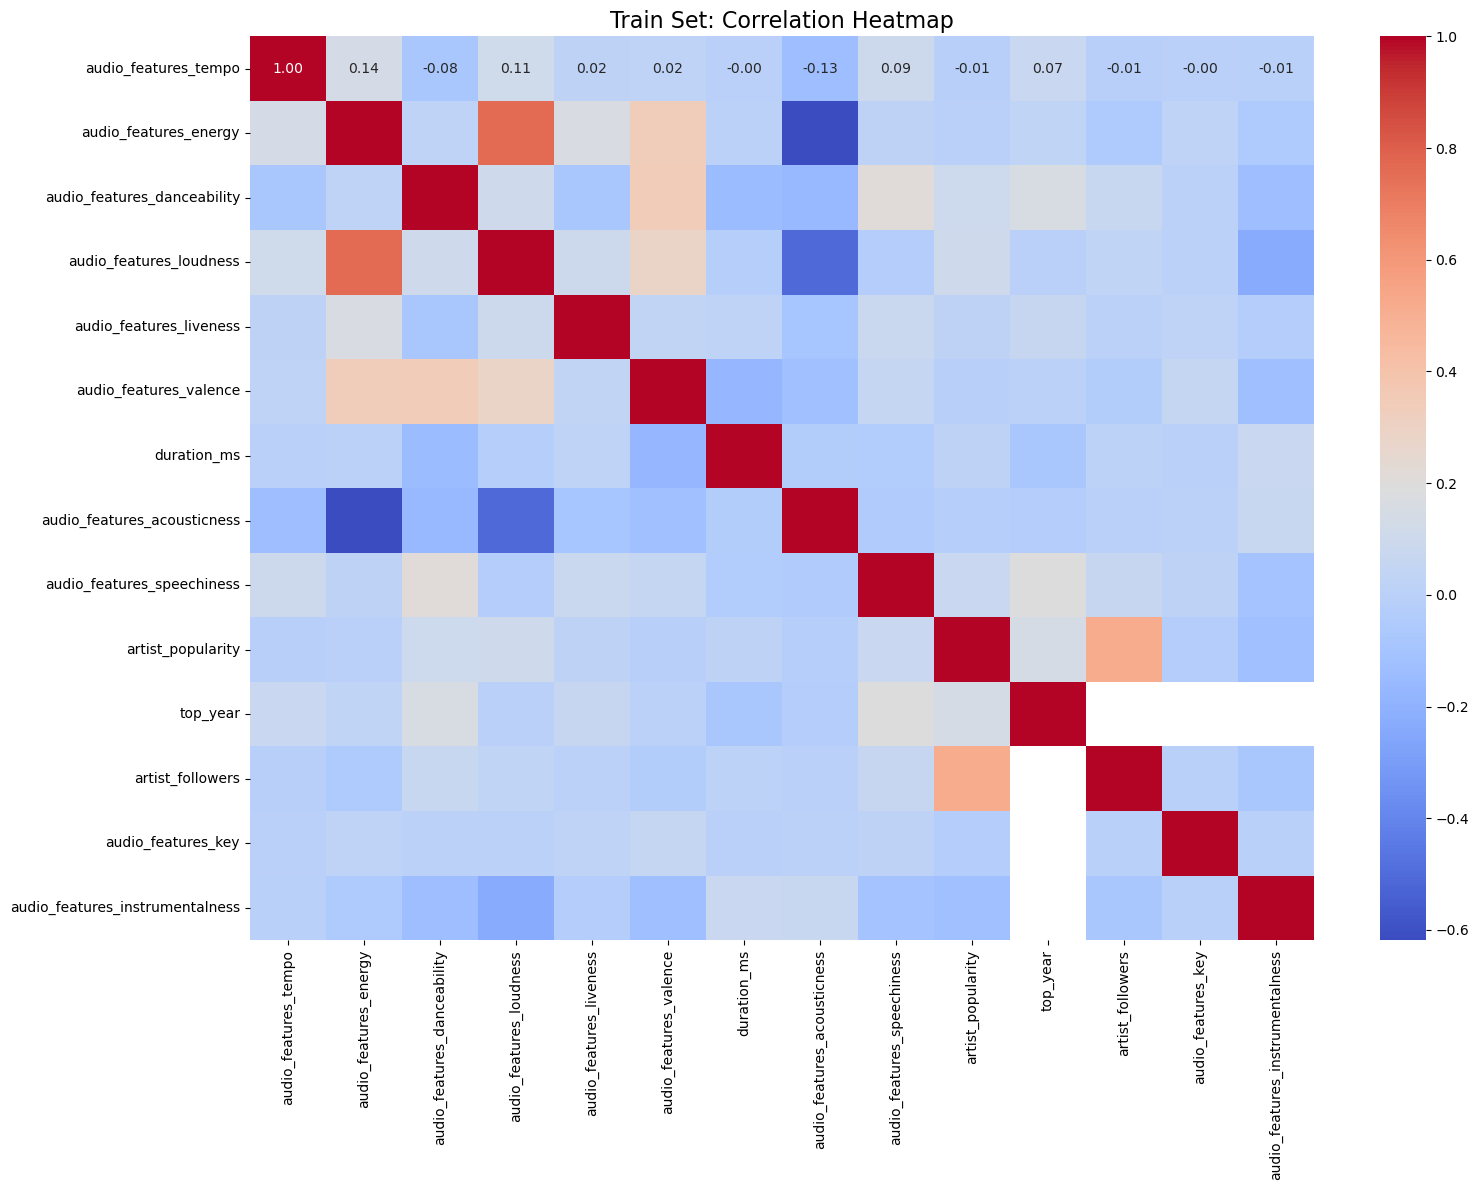

In [19]:
# Train set visualizations
plot_histograms(train_set, continuous_vars, 'Train Set: Continuous Variable Distributions')
plot_boxplots(train_set, continuous_vars, 'Train Set: Continuous Variable Boxplots')
plot_correlation_heatmap(train_set, continuous_vars, 'Train Set: Correlation Heatmap')


#### Data Visualization for Testing Set




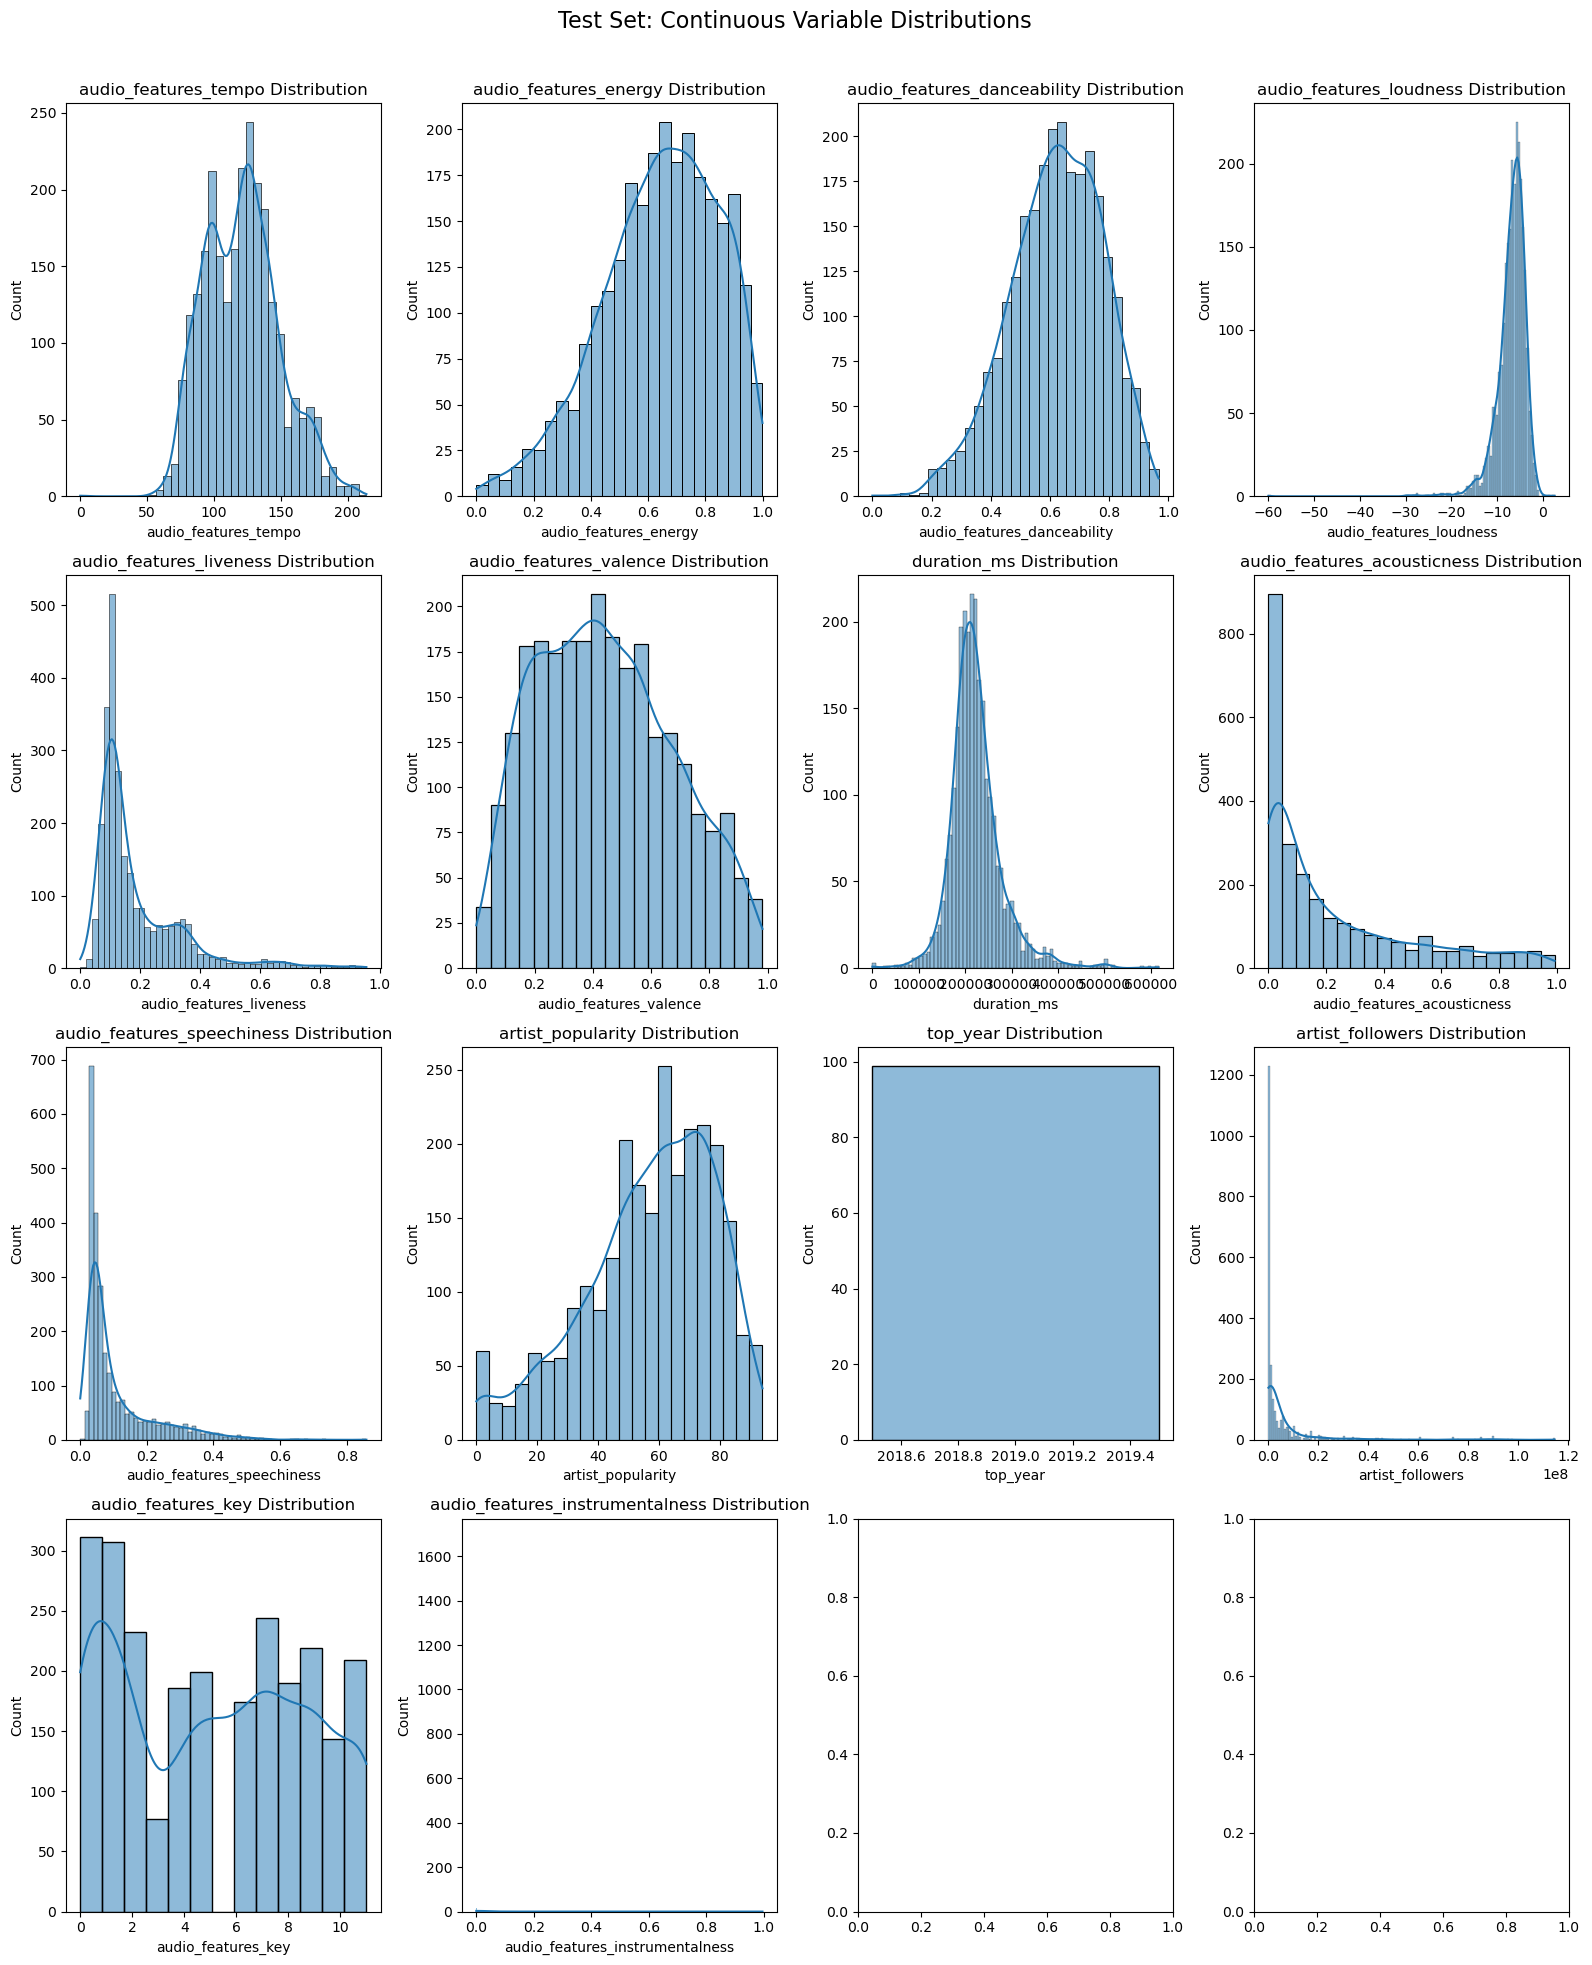

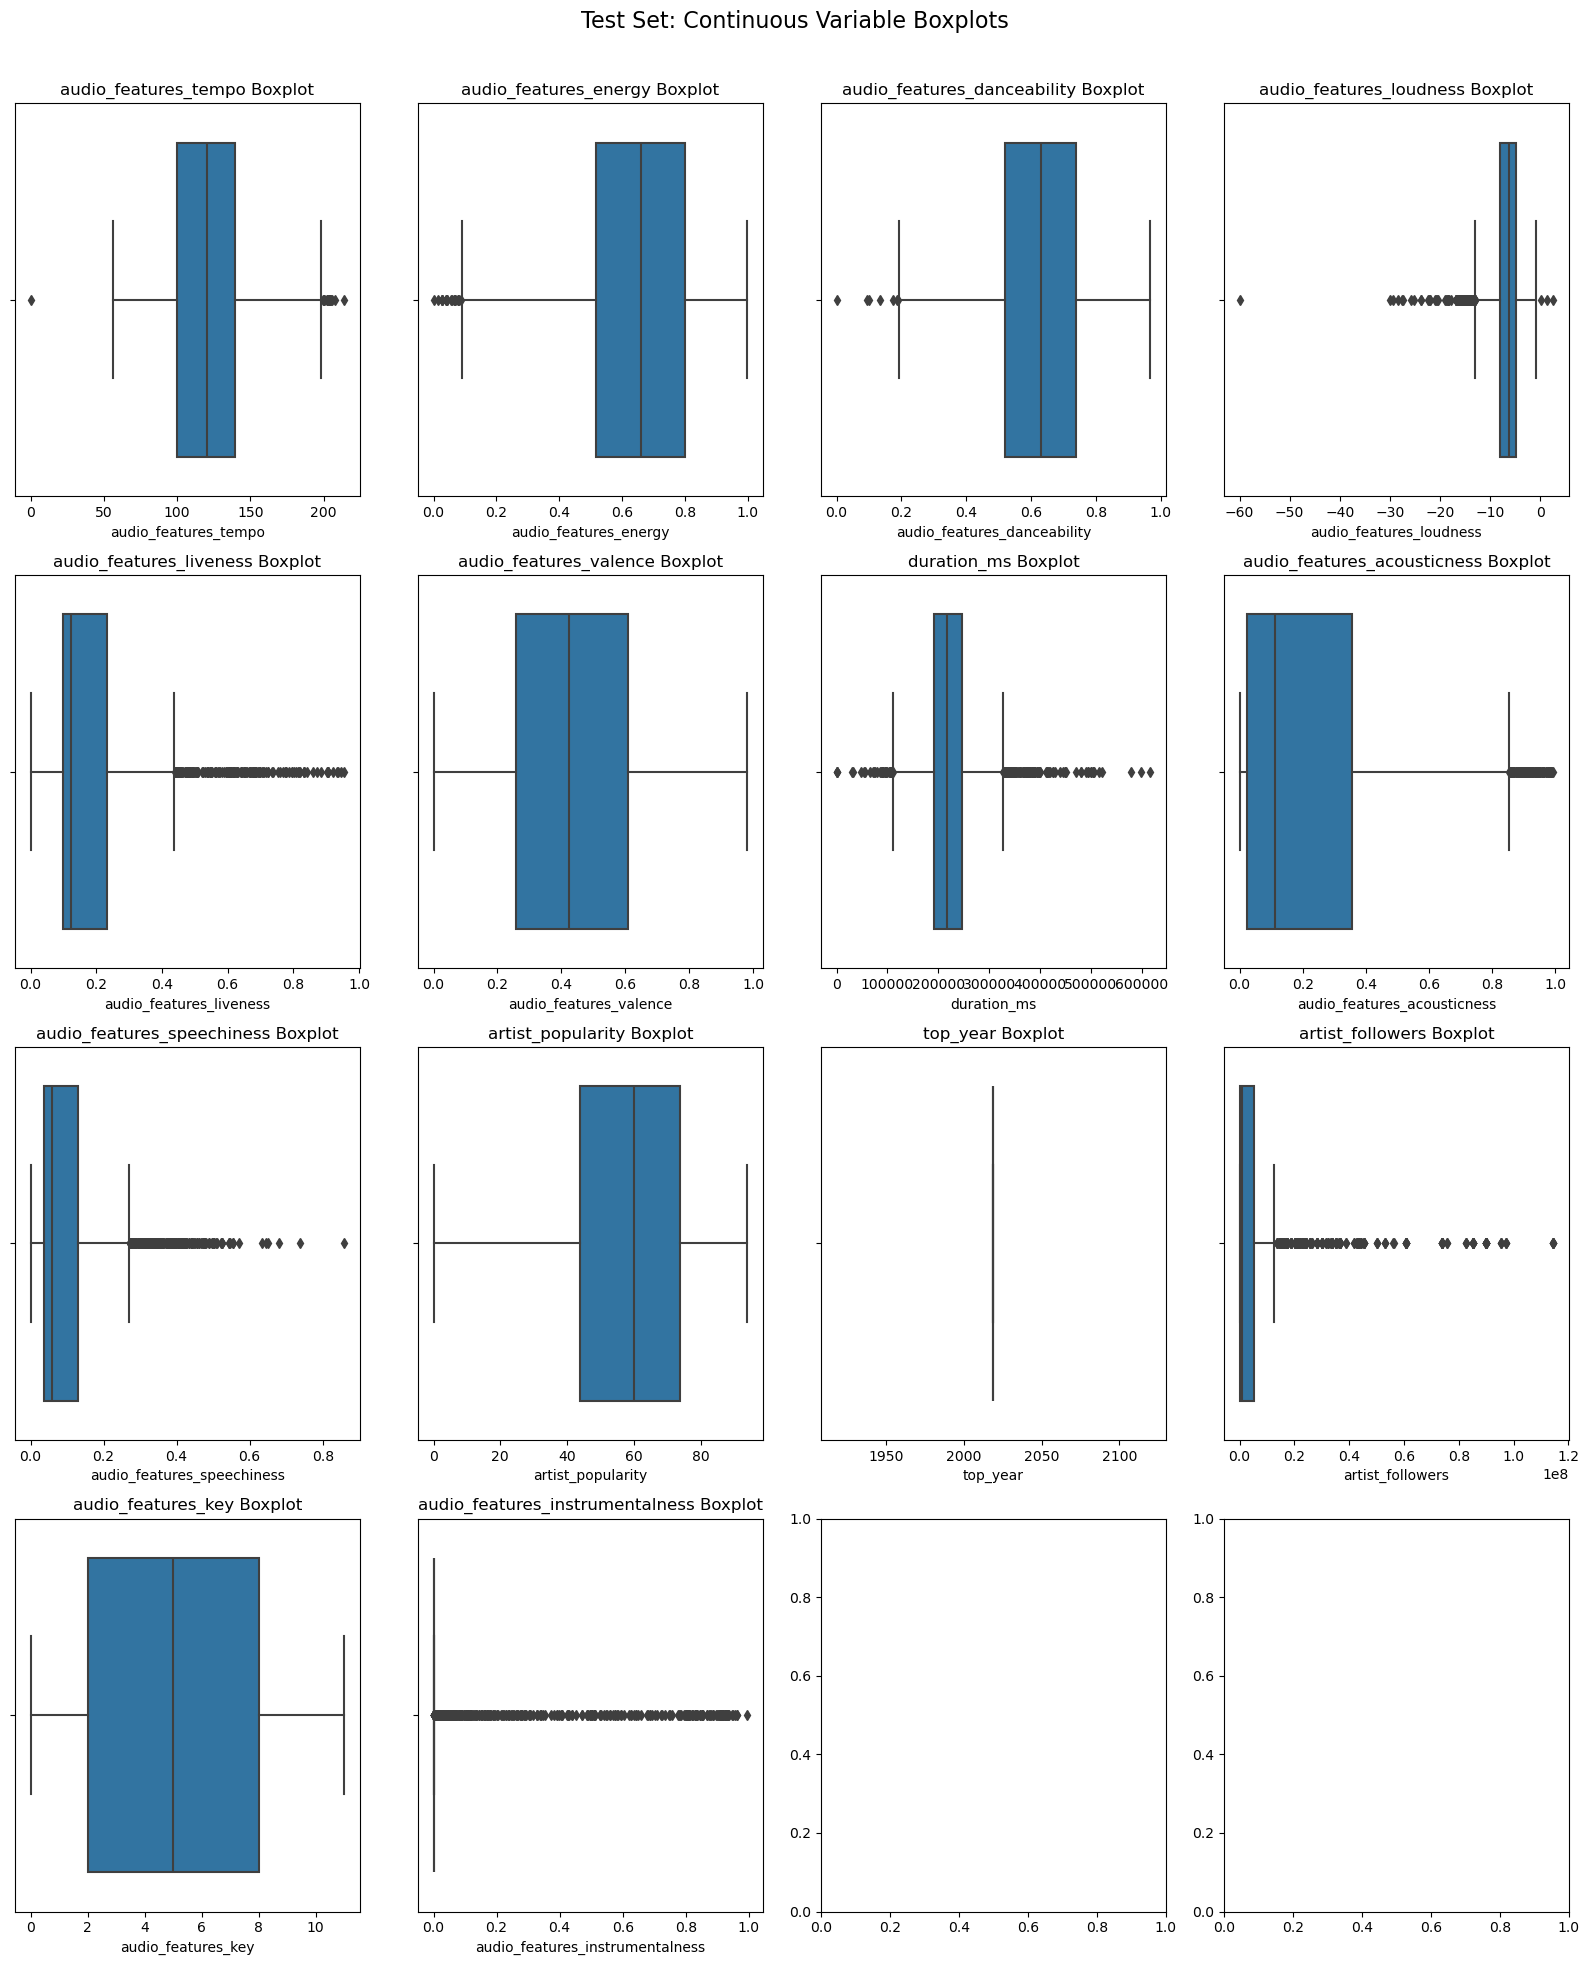

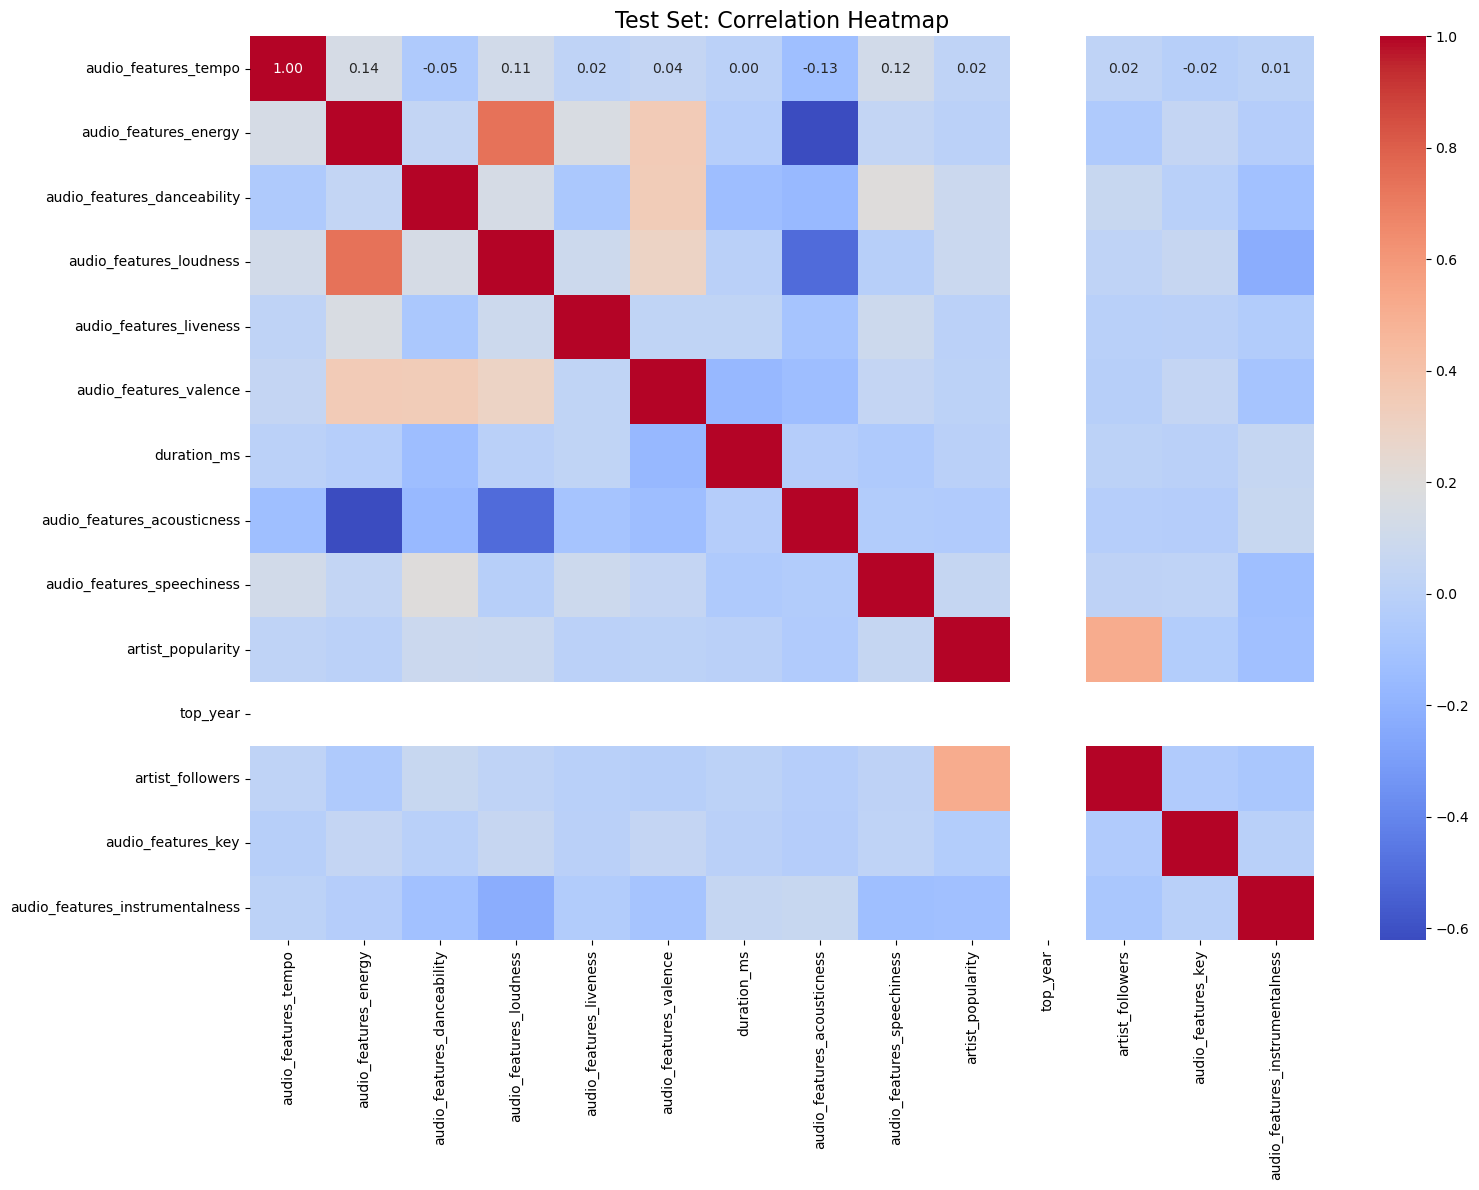

In [20]:
# Test set visualizations
plot_histograms(test_set, continuous_vars, 'Test Set: Continuous Variable Distributions')
plot_boxplots(test_set, continuous_vars, 'Test Set: Continuous Variable Boxplots')
plot_correlation_heatmap(test_set, continuous_vars, 'Test Set: Correlation Heatmap')

## 4 Data Cleaning and Transformation

In [20]:
# Columns to drop
cols_to_drop = [
    'album_name',
    'artist_followers',
    'album_type',
    'audio_features_key',
    'audio_features_mode',
    'audio_features_instrumentalness',
    'audio_features_time_signature',
    'added',
    'top_year',
    'artist_type'
]

# Drop the specified columns from the training and testing sets
train_set.drop(columns=cols_to_drop, inplace=True)
test_set.drop(columns=cols_to_drop, inplace=True)

#### Patch Column Data: Impute Missing Data:
For `artist_popularity`, we will use mean imputation to fill in the missing values. Mean imputation is a straightforward and effective technique for numerical data where the missing values are replaced with the mean value of the available data. This approach maintains the central tendency of the data and is appropriate when the missing data is relatively small compared to the dataset size.

For `artist_genres`, quite a number of non-top100 data are missing. We will patch them using appropriate techniques such as K-Nearest Neighbors (KNN) imputation to fill in the missing values.

Using K-Nearest Neighbors (KNN) for imputation can be effective for filling missing values, especially when the data points have a meaningful similarity. However, for `artist_genres`, it can be more challenging because it requires determining a distance metric that makes sense for categorical data and identifying the appropriate features to base the imputation on.

We will be using the following audio features which can describe the vibe of the music to impute genres:
- `artist_genres_encoded`
- `audio_features_tempo`
- `audio_features_energy`
- `audio_features_danceability`
- `audio_features_loudness`
- `audio_features_liveness`
- `audio_features_valence`
- `audio_features_acousticness`
- `audio_features_speechiness`



In [22]:
# Impute artist popularity using mean
train_set['artist_popularity'].fillna(train_set['artist_popularity'].mean(), inplace=True)
test_set['artist_popularity'].fillna(test_set['artist_popularity'].mean(), inplace=True)

combined_genres = pd.concat([train_set['artist_genres'], test_set['artist_genres']], axis=0)

label_encoder = LabelEncoder()

combined_genres_non_na = combined_genres.dropna().astype(str)  # Only non-NA values for fitting
label_encoder.fit(combined_genres_non_na)

# Temporary variables for transformation
train_genres_non_na = train_set['artist_genres'].dropna().astype(str)
test_genres_non_na = test_set['artist_genres'].dropna().astype(str)

# Create a new column with placeholder for encoded values
train_set['artist_genres_encoded'] = np.nan
test_set['artist_genres_encoded'] = np.nan

# Fill in non-NA encoded values
train_set.loc[train_genres_non_na.index, 'artist_genres_encoded'] = label_encoder.transform(train_genres_non_na)
test_set.loc[test_genres_non_na.index, 'artist_genres_encoded'] = label_encoder.transform(test_genres_non_na)

features_for_imputation = [
    'audio_features_tempo',
    'audio_features_energy',
    'audio_features_danceability',
    'audio_features_loudness',
    'audio_features_liveness',
    'audio_features_valence',
    'audio_features_acousticness',
    'audio_features_speechiness',
    'artist_popularity',
]

imputer = KNNImputer(n_neighbors=5)

# Impute only on the selected features
train_features_imputed = imputer.fit_transform(train_set[features_for_imputation])
test_features_imputed = imputer.transform(test_set[features_for_imputation])

# Replace the original features with the imputed ones
train_set[features_for_imputation] = train_features_imputed
test_set[features_for_imputation] = test_features_imputed

# Now combine datasets to impute 'artist_genres_encoded' using the imputed features
combined_for_imputation = pd.concat([train_set[['artist_genres_encoded'] + features_for_imputation], 
                                     test_set[['artist_genres_encoded'] + features_for_imputation]], axis=0)

imputed_combined = imputer.fit_transform(combined_for_imputation)

# Split the imputed values back into training and test sets
train_set['artist_genres_encoded'] = imputed_combined[:len(train_set), 0]
test_set['artist_genres_encoded'] = imputed_combined[len(train_set):, 0]

train_set['artist_genres'] = label_encoder.inverse_transform(train_set['artist_genres_encoded'].astype(int))
test_set['artist_genres'] = label_encoder.inverse_transform(test_set['artist_genres_encoded'].astype(int))

train_set.drop(columns=['artist_genres_encoded'], inplace=True)
test_set.drop(columns=['artist_genres_encoded'], inplace=True)

print('train_set.isnull().sum()')
print(train_set.isnull().sum())

print('test_set.isnull().sum()')
print(test_set.isnull().sum())


train_set.isnull().sum()
track_name                     0
artist_name                    0
artist_genres                  0
album_release_date             0
audio_features_tempo           0
audio_features_energy          0
audio_features_danceability    0
audio_features_loudness        0
audio_features_liveness        0
audio_features_valence         0
duration_ms                    0
audio_features_acousticness    0
audio_features_speechiness     0
artist_popularity              0
isTop100                       0
dtype: int64
test_set.isnull().sum()
track_name                     0
artist_name                    0
artist_genres                  0
album_release_date             0
audio_features_tempo           0
audio_features_energy          0
audio_features_danceability    0
audio_features_loudness        0
audio_features_liveness        0
audio_features_valence         0
duration_ms                    0
audio_features_acousticness    0
audio_features_speechiness     0
artist_popular

### 4.2 Data Transformation

#### 4.2.1 Encoding Categorical Variables
We started by analyzing the unique genres in our dataset. After cleaning and splitting the genre strings, we found that there are over 1000 unique genres in the train sets and over 900 in the test sets.

Given the large number of unique genres, we decided to focus on the top 100 genres. This decision was based on the observation that the top 100 genres have a decent coverage of our dataset. Below are the steps taken to clean, encode, and ensure consistency of genres in our dataset:

1) **Cleaning Genres**: We apply a function to clean and split the genre strings, converting them to lowercase and removing extra spaces.
2) **Calculating Frequency**: We calculate the frequency of each genre in the training set and identify the top 100 genres.
3) **Ensuring Consistency**: We ensure that the 'other' category is included in the genre columns to capture any genres outside the top 100.
4) **Encoding Genres**: We encode the genres based on the top 100 and add these one-hot encoded columns back to the original datasets.
5) **Dropping Temporary Columns**: We remove temporary columns used for encoding to clean up the datasets.
6) **Ensuring Column Consistency**: We ensure that the test set has the same columns as the training set by adding any missing genre columns with a value of 0.


In [24]:
# Function to clean genres
def clean_genres(genre_str):
    if isinstance(genre_str, str):
        return [genre.strip().lower() for genre in genre_str.split(',')]
    return []

# Clean genres in the training and test sets
train_set['cleaned_genres'] = train_set['artist_genres'].apply(clean_genres)
test_set['cleaned_genres'] = test_set['artist_genres'].apply(clean_genres)

# Flatten the list of genres to get the frequency of each genre in the training set
all_train_genres = [genre for sublist in train_set['cleaned_genres'] for genre in sublist]
train_genre_counts = pd.Series(all_train_genres).value_counts()

# Get the top 100 genres in the training set
top_100_train_genres = train_genre_counts.head(100).index.tolist()

# Ensure 'other' is included in the genre columns
if 'other' not in top_100_train_genres:
    top_100_train_genres.append('other')
    
# Function to encode genres based on the top 100
def encode_top_genres(cleaned_genres, top_genres):
    genre_set = set(cleaned_genres)
    encoded = {genre: (1 if genre in genre_set else 0) for genre in top_genres}
    encoded['other'] = 1 if not genre_set.isdisjoint(set(top_genres)) else 0
    return encoded

# Encode genres in the training set
train_set['genre_encoding'] = train_set['cleaned_genres'].apply(lambda x: encode_top_genres(x, top_100_train_genres))
train_genres_encoded = pd.json_normalize(train_set['genre_encoding'])

# Concatenate the one-hot encoded genres back to the training dataset
train_set = pd.concat([train_set, train_genres_encoded], axis=1)

# Drop temporary columns used for encoding
train_set.drop(columns=['cleaned_genres', 'genre_encoding', 'artist_genres'], inplace=True)

# Repeat the same process for the test set
# Encode genres in the test set using top genres from the training set
test_set['genre_encoding'] = test_set['cleaned_genres'].apply(lambda x: encode_top_genres(x, top_100_train_genres))
test_genres_encoded = pd.json_normalize(test_set['genre_encoding'])

# Concatenate the one-hot encoded genres back to the test dataset
test_set = pd.concat([test_set, test_genres_encoded], axis=1)

# Drop temporary columns used for encoding
test_set.drop(columns=['cleaned_genres', 'genre_encoding', 'artist_genres'], inplace=True)

# List of one-hot encoded genre columns from the top genres
train_genre_columns = top_100_train_genres

# Ensure the test set has the same columns as the training set
missing_genre_cols = set(train_genre_columns) - set(test_set.columns)
for col in missing_genre_cols:
    test_set[col] = 0
test_set = test_set[train_set.columns]


#### 4.2.2 Log Transformation
Log transformation is applied to skewed numeric features to normalize their distribution, improving model performance by reducing the impact of extreme values.

We identified that `artist_popularity`, `audio_features_energy`, `audio_features_danceability`, and `duration_ms` are left-skewed, and will benefit from log transformation.

For `audio_features_loudness`, which is left-skewed with negative values, we will apply scaling instead. Additionally, `audio_features_valence` and `audio_features_acousticness` are right-skewed and will also undergo log transformation.

Skewness before transformation:
artist_popularity             -0.656139
audio_features_energy         -0.492050
audio_features_danceability   -0.356667
duration_ms                    1.729825
audio_features_valence         0.281132
audio_features_acousticness    1.237573
audio_features_loudness       -1.587114
dtype: float64

Skewness after transformation:
artist_popularity             -3.349698
audio_features_energy         -0.804080
audio_features_danceability   -0.635851
duration_ms                   -7.137871
audio_features_valence         0.007980
audio_features_acousticness    0.990001
audio_features_loudness       -1.587114
dtype: float64



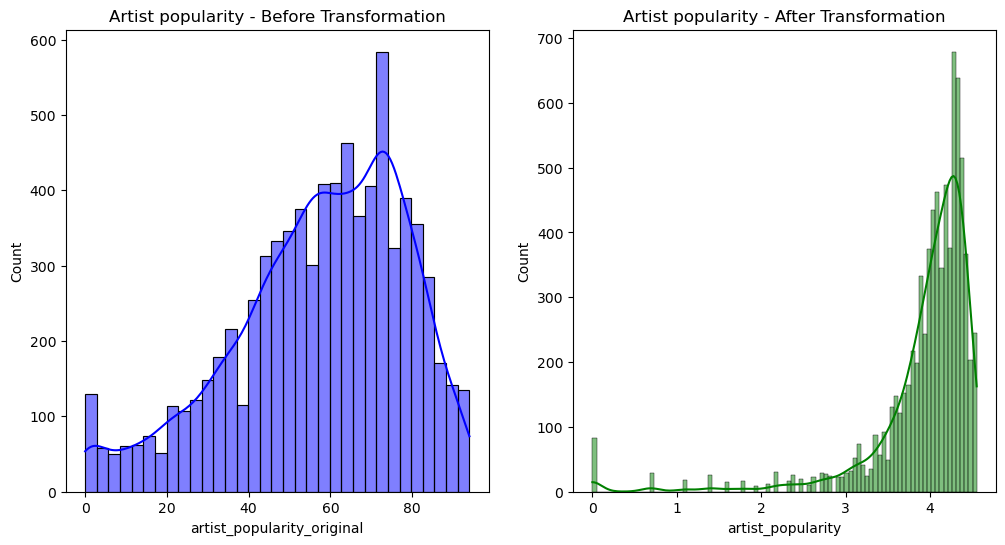

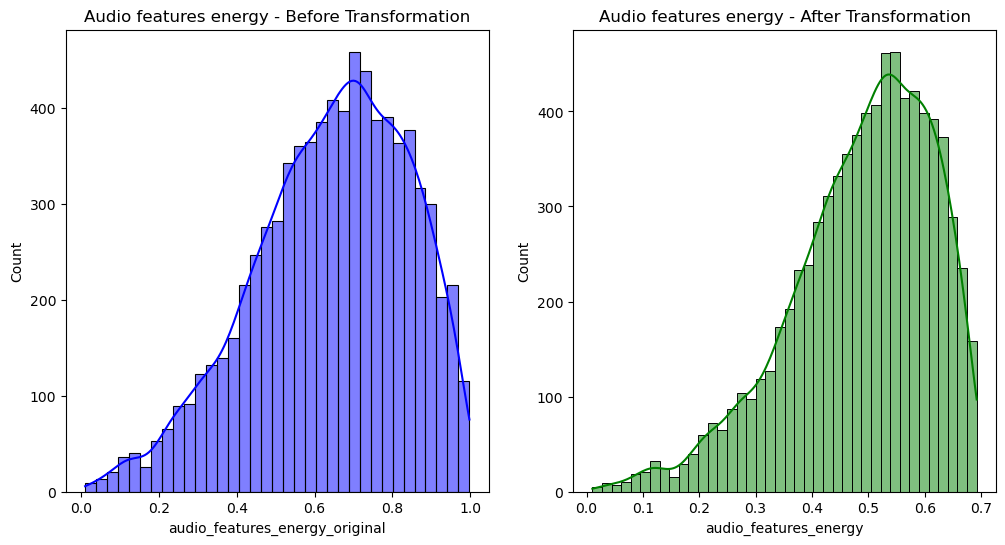

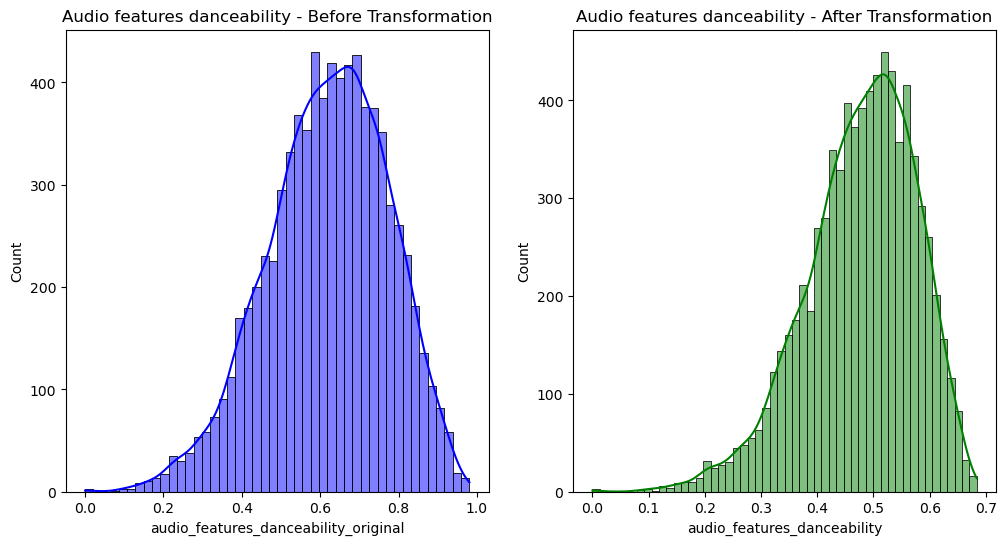

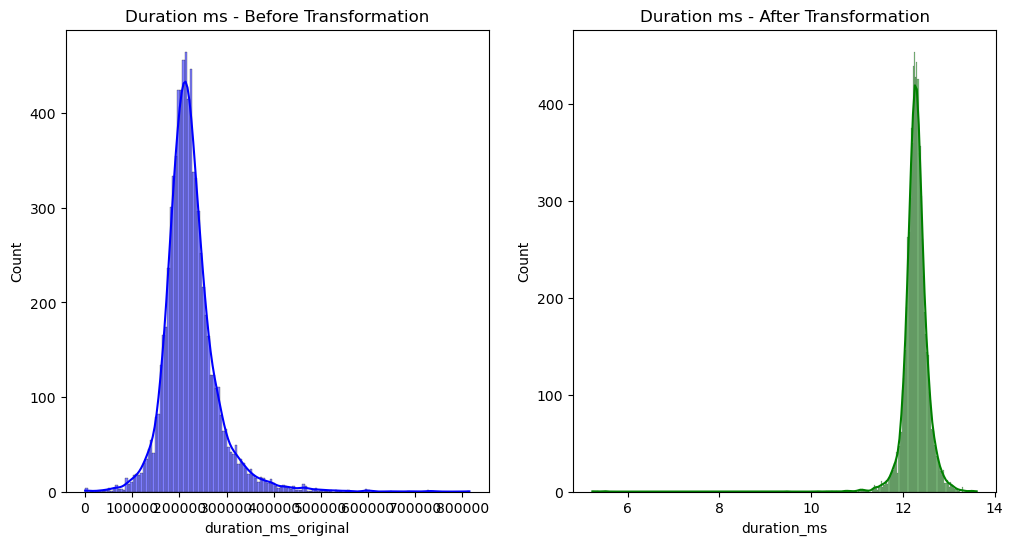

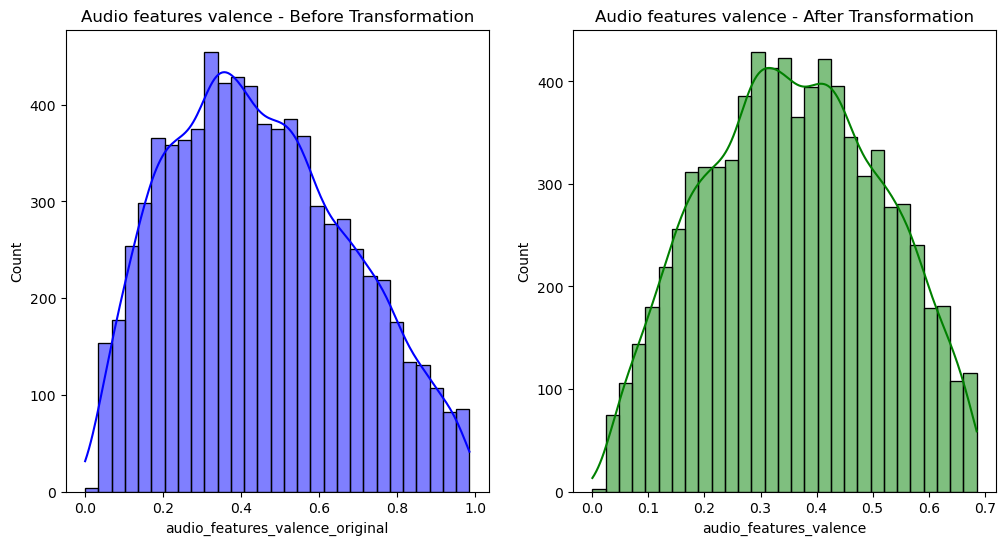

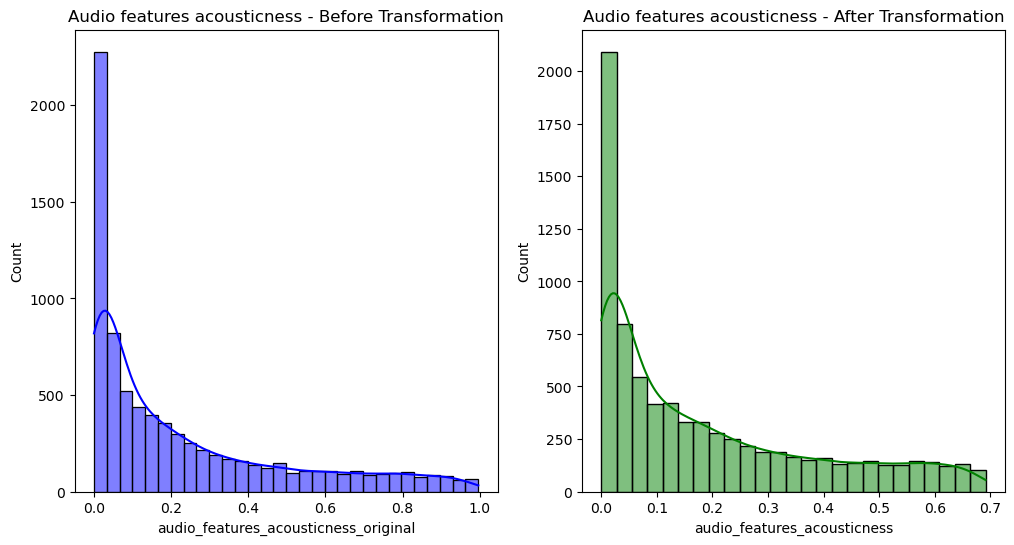

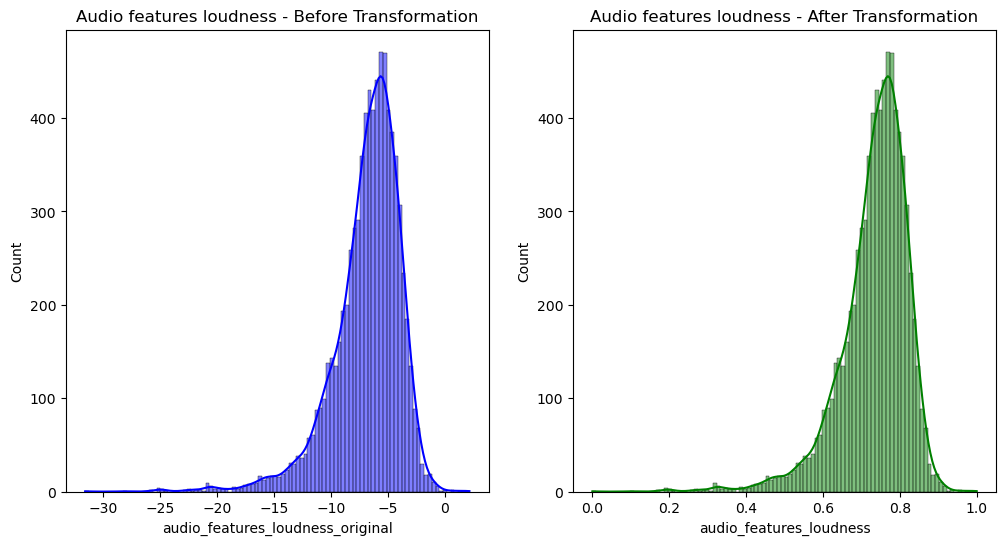

In [26]:
# List of all skewed features including the new ones
skewed_features_left = ['artist_popularity', 'audio_features_energy', 'audio_features_danceability', 'duration_ms']
skewed_features_right = ['audio_features_valence', 'audio_features_acousticness']

# Add original columns for the new features
all_skewed_features = skewed_features_left + skewed_features_right + ['audio_features_loudness']
for feature in all_skewed_features:
    train_set[f'{feature}_original'] = train_set[feature]
    test_set[f'{feature}_original'] = test_set[feature]

# Function to calculate and print skewness
def print_skewness(df, features, label):
    skewness = df[features].apply(skew)
    print(f"Skewness {label}:")
    print(skewness)
    print()

# Calculate and print skewness before transformation
print_skewness(train_set, all_skewed_features, "before transformation")

# Apply log transformation to left-skewed features
for feature in skewed_features_left + skewed_features_right:
    train_set[feature] = np.log1p(train_set[feature])
    test_set[feature] = np.log1p(test_set[feature])

# Apply MinMax scaling to audio_features_loudness due to negative values
scaler_loudness = MinMaxScaler()
train_set['audio_features_loudness'] = scaler_loudness.fit_transform(train_set[['audio_features_loudness']])
test_set['audio_features_loudness'] = scaler_loudness.transform(test_set[['audio_features_loudness']])

# Calculate and print skewness after transformation
print_skewness(train_set, all_skewed_features, "after transformation")

# Function to plot the before and after transformation
def plot_distributions(feature, transformed_feature, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train_set[feature], kde=True, color='blue')
    plt.title(f'{title} - Before Transformation')

    plt.subplot(1, 2, 2)
    sns.histplot(train_set[transformed_feature], kde=True, color='green')
    plt.title(f'{title} - After Transformation')

    plt.show()

# Plot distributions for all features
for feature in all_skewed_features:
    plot_distributions(f'{feature}_original', feature, feature.replace('_', ' ').capitalize())

# # Drop the original and scaled versions we are not using
# train_set.drop(columns=[f'{feature}_original' for feature in all_skewed_features], inplace=True)
# test_set.drop(columns=[f'{feature}_original' for feature in all_skewed_features], inplace=True)

# # Verify the resulting DataFrames
# print(train_set.head())
# print(test_set.head())


After applying these transformations, we observed the following results:

- `Artist Popularity`: The log transformation increased the negative skewness. Since it did not improve the distribution, we will revert to the original values.
- `Audio Features Energy`: The log transformation slightly increased the skewness, but the impact is minimal. We will keep the transformed values for now but could consider reverting if needed.
- `Audio Features Danceability`: The log transformation increased the negative skewness. We will revert to the original values.
- `Duration (in ms)`: The log transformation caused the distribution to become highly negatively skewed. We will revert to the original values.
- `Audio Features Valence`: The log transformation improved the distribution, making it nearly normal. We will keep the transformed values.
- `Audio Features Acousticness`: The log transformation reduced the skewness, improving the distribution. We will keep the transformed values.
- `Audio Features Loudness`: The MinMax scaling did not change the skewness, so we will revert to the original values.


- `Artist Popularity`: The log transformation increased the negative skewness. As it did not improve the distribution, we will revert to the original values.
- `Audio Features Loudness`: The MinMax scaling did not change the skewness, so we will keep the original values.
- `Duration (in ms)`: The log transformation after handling outliers improved the distribution, so we will keep the transformed values.

In [28]:
# Revert to original for non-improved features
features_to_revert = ['artist_popularity', 'audio_features_danceability', 'duration_ms', 'audio_features_loudness']

for feature in features_to_revert:
    train_set[feature] = train_set[f'{feature}_original']
    test_set[feature] = test_set[f'{feature}_original']

# Drop all original versions of the features
all_original_features = [f'{feature}_original' for feature in all_skewed_features]

train_set.drop(columns=all_original_features, inplace=True)
test_set.drop(columns=all_original_features, inplace=True)

# Verify the resulting DataFrames
print(train_set.head())
print(test_set.head())


              track_name    artist_name album_release_date  \
0          Hurts So Good       Astrid S         2016-01-01   
1                   Gold         Kiiara         2015-01-01   
2  When You Love Someone       James TW         2019-01-01   
3                 Alaska  Maggie Rogers         2019-01-01   
4                   NUMB   Hayden James         2019-01-01   

   audio_features_tempo  audio_features_energy  audio_features_danceability  \
0                 120.0               0.552159                        0.785   
1                 113.0               0.528273                        0.629   
2                 126.0               0.373630                        0.682   
3                 104.0               0.326422                        0.847   
4                 148.0               0.625938                        0.488   

   audio_features_loudness  audio_features_liveness  audio_features_valence  \
0                   -5.306                   0.1080                0.6785

#### 4.2.3 DateTime Transformation
To make the album_release_date column suitable for modeling, we convert it to a numeric format. Machine learning algorithms require numerical input, and DateTime features can be challenging to work with directly. By converting the album_release_date to the number of days since a reference date (Unix epoch: January 1, 1970), we can effectively incorporate this temporal information into our models. This transformation ensures that the model can understand the passage of time and its potential impact on the target variable.

In [30]:
# Convert 'album_release_date' to numeric (days since Unix epoch)
train_set['album_release_date'] = (train_set['album_release_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
test_set['album_release_date'] = (test_set['album_release_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')


#### 4.2.4 Dropping Identifying Features
We drop the identifying features `track_name` and `artist_name` to prevent the model from potentially memorizing specific songs or artists, which could lead to overfitting.

In [32]:
# Drop identifying features
features_to_drop = ['track_name', 'artist_name']
train_set = train_set.drop(columns=features_to_drop)
test_set = test_set.drop(columns=features_to_drop)


## 5 Dimensionality Reduction and Feature Engineering

### 5.1 Dimensionality Reduction

Given that we have 116 columns after one-hot encoding the genres, it is crucial to consider dimensionality reduction techniques to avoid the curse of dimensionality, which can lead to overfitting and increased computational complexity. One effective method for dimensionality reduction is Principal Component Analysis (PCA).

PCA helps in reducing the number of features while retaining most of the variance in the dataset. By transforming the original features into a new set of uncorrelated features (principal components), PCA captures the essential information with fewer dimensions.

We choose the number of principal components (`n_components`) based on the explained variance ratio. This ensures that we retain enough information to maintain the predictive power of the dataset while significantly reducing the dimensionality. For our dataset, we select `n_components=10`, which provides a balance between dimensionality reduction and information retention.


In [34]:
# Apply StandardScaler to scale the genre columns before PCA
scaler = StandardScaler()
train_genres_scaled = scaler.fit_transform(train_set[train_genre_columns])

# Apply PCA to reduce dimensionality for the training set
pca = PCA(n_components=10)  # Choose the number of components based on explained variance
train_genres_pca = pca.fit_transform(train_genres_scaled)

# Convert PCA results back to DataFrame and concatenate with original training dataset
train_genres_pca_df = pd.DataFrame(train_genres_pca, columns=[f'pca_genre_{i+1}' for i in range(train_genres_pca.shape[1])])
train_set = pd.concat([train_set.reset_index(drop=True), train_genres_pca_df.reset_index(drop=True)], axis=1)

# Drop original one-hot encoded genre columns from the training set
train_set.drop(columns=train_genre_columns, inplace=True)


# Apply the transformations to the test set using the scaler and PCA fitted on the training set
test_genres_scaled = scaler.transform(test_set[train_genre_columns])
test_genres_pca = pca.transform(test_genres_scaled)

# Convert PCA results back to DataFrame and concatenate with original test dataset
test_genres_pca_df = pd.DataFrame(test_genres_pca, columns=[f'pca_genre_{i+1}' for i in range(test_genres_pca.shape[1])])
test_set = pd.concat([test_set.reset_index(drop=True), test_genres_pca_df.reset_index(drop=True)], axis=1)

# Drop original one-hot encoded genre columns from the test set
test_set.drop(columns=train_genre_columns, inplace=True)

# Verify the resulting DataFrames
print(train_set.head())
print(test_set.head())


   album_release_date  audio_features_tempo  audio_features_energy  \
0               16801                 120.0               0.552159   
1               16436                 113.0               0.528273   
2               17897                 126.0               0.373630   
3               17897                 104.0               0.326422   
4               17897                 148.0               0.625938   

   audio_features_danceability  audio_features_loudness  \
0                        0.785                   -5.306   
1                        0.629                   -5.572   
2                        0.682                   -6.090   
3                        0.847                  -10.668   
4                        0.488                   -4.185   

   audio_features_liveness  audio_features_valence  duration_ms  \
0                   0.1080                0.678541       218960   
1                   0.0554                0.484276       207627   
2                   0.0

In [36]:
print('train_set.isnull().sum()')
print(train_set.isnull().sum())

print('test_set.isnull().sum()')
print(test_set.isnull().sum())

train_set.isnull().sum()
album_release_date             0
audio_features_tempo           0
audio_features_energy          0
audio_features_danceability    0
audio_features_loudness        0
audio_features_liveness        0
audio_features_valence         0
duration_ms                    0
audio_features_acousticness    0
audio_features_speechiness     0
artist_popularity              0
isTop100                       0
pca_genre_1                    0
pca_genre_2                    0
pca_genre_3                    0
pca_genre_4                    0
pca_genre_5                    0
pca_genre_6                    0
pca_genre_7                    0
pca_genre_8                    0
pca_genre_9                    0
pca_genre_10                   0
dtype: int64
test_set.isnull().sum()
album_release_date             0
audio_features_tempo           0
audio_features_energy          0
audio_features_danceability    0
audio_features_loudness        0
audio_features_liveness        0
audio_features

### 5.2 Feature Creation
Feature creation involves generating new features from existing ones to enhance the model's predictive power. By creating interaction terms or aggregating features, we can provide the model with additional information that may improve its performance.

For example, we can create interaction terms between different audio features, such as `tempo` and `danceability`, to capture the combined effect of these features on the target variable.

In [38]:
# Create interaction term between tempo and danceability
train_set['tempo_danceability_interaction'] = train_set['audio_features_tempo'] * train_set['audio_features_danceability']
test_set['tempo_danceability_interaction'] = test_set['audio_features_tempo'] * test_set['audio_features_danceability']


### 5.3 OverSampling
In our training set, it has a significant imbalance between the non-Top 100 songs and the Top 100 songs, with over 7000 non-Top 100 instances compared to only 300 Top 100 instances.

To address this imbalance, we use the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples for the minority class (Top 100 songs) by interpolating between existing minority class samples. This helps to create a more balanced dataset, which can lead to better model performance and more accurate predictions.

In [40]:
# Separate features and target variable
X_train = train_set.drop(columns=['isTop100'])
y_train = train_set['isTop100']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Update train_set with resampled data
train_set_resampled = pd.concat([X_train_res, y_train_res], axis=1)

print(train_set_resampled.shape)

(15090, 23)


### 5.4 Feature Selection
Feature selection is a crucial step in building a robust machine learning model. It helps in identifying and retaining the most relevant features that contribute to the target variable. This step involves two main processes: using Random Forest to determine feature importance and removing highly correlated features.

#### 5.4.1 Feature Selection with Random Forest
We use the Random Forest classifier to determine the importance of each feature. Random Forest is an ensemble learning method that combines multiple decision trees to improve the model's accuracy and robustness. It also provides feature importance scores, which help in selecting the most relevant features for the model.

To enhance the reliability of our feature selection process, we implemented a Stratified K-Fold Cross-Validation approach. This involves splitting the training data into multiple folds, training the Random Forest model on each fold, and identifying features that are consistently important across these folds.To enhance the reliability of our feature selection process, we implemented a Stratified K-Fold Cross-Validation approach. This involves splitting the training data into multiple folds, training the Random Forest model on each fold, and identifying features that are consistently important across these folds.

In [45]:
# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

selected_features = np.zeros(train_set_resampled.drop(columns=['isTop100']).shape[1])
for train_idx, val_idx in kf.split(train_set_resampled, train_set_resampled['isTop100']):
    X_train_cv, X_val_cv = train_set_resampled.drop(columns=['isTop100']).iloc[train_idx], train_set_resampled.drop(columns=['isTop100']).iloc[val_idx]
    y_train_cv, y_val_cv = train_set_resampled['isTop100'].iloc[train_idx], train_set_resampled['isTop100'].iloc[val_idx]
    
    # Train the model
    model.fit(X_train_cv, y_train_cv)
    
    # Select features
    selector = SelectFromModel(model, prefit=True)
    selected_features += selector.get_support().astype(int)

# Select features that were consistently selected across folds
selected_features = selected_features >= kf.get_n_splits()
selected_feature_names = train_set_resampled.drop(columns=['isTop100']).columns[selected_features]
print(selected_feature_names)

# Update train and test sets to include only selected features
train_selected = selector.transform(train_set_resampled.drop(columns=['isTop100']))
test_selected = selector.transform(test_set.drop(columns=['isTop100']))

train_set_selected = pd.DataFrame(train_selected, columns=selected_feature_names)
test_set_selected = pd.DataFrame(test_selected, columns=selected_feature_names)
train_set_selected['isTop100'] = train_set_resampled['isTop100'].values
test_set_selected['isTop100'] = test_set['isTop100'].values


Index(['artist_popularity', 'pca_genre_1', 'pca_genre_3', 'pca_genre_4',
       'pca_genre_5', 'pca_genre_6', 'pca_genre_7', 'pca_genre_9'],
      dtype='object')


#### 5.4.2 Removing Highly Correlated Features
After selecting features based on their importance, we further refine our feature set by removing features that are highly correlated with the target variable. This step helps prevent multicollinearity, which can negatively impact model performance.

In [46]:
# Calculate correlation with the target variable for all features
correlations = train_set_selected.corr()

# Identify features with high correlation with the target
highly_correlated_features = correlations['isTop100'].abs().sort_values(ascending=False)

# Print the correlations of the features to be removed
print("Correlations with 'isTop100':")
print(highly_correlated_features)

# Define the threshold for high correlation
correlation_threshold = 0.95

# Identify features to remove based on the threshold
features_to_remove = highly_correlated_features[highly_correlated_features > correlation_threshold].index.tolist()
features_to_remove.remove('isTop100')  # Remove the target variable itself from the list

print("Highly correlated features with the target:", features_to_remove)

# Now remove these highly correlated features from the training and test sets
train_set_selected = train_set_selected.drop(columns=features_to_remove)
test_set_selected = test_set_selected.drop(columns=features_to_remove)

# Update the selected features list
selected_features = [feature for feature in train_set_selected.columns if feature != 'isTop100']

print("Final Selected Features:", selected_features)


Correlations with 'isTop100':
isTop100             1.000000
artist_popularity    0.548114
pca_genre_7          0.286620
pca_genre_6          0.099012
pca_genre_4          0.088710
pca_genre_3          0.086449
pca_genre_9          0.023828
pca_genre_5          0.022087
pca_genre_1          0.017125
Name: isTop100, dtype: float64
Highly correlated features with the target: []
Final Selected Features: ['artist_popularity', 'pca_genre_1', 'pca_genre_3', 'pca_genre_4', 'pca_genre_5', 'pca_genre_6', 'pca_genre_7', 'pca_genre_9']


## 6 Baseline Models

### Heuristic Approach
The heuristic approach is based on simple rules derived from the training data. We use the median artist_popularity and the 75th percentile of album_release_date as thresholds for prediction. If a song's artist_popularity is above the median or its album_release_date is within the top 25% most recent releases, we predict it to be in the Top 100.

This heuristic approach serves as a baseline for later comparison with more complex machine learning models. By establishing a simple rule-based model, we can evaluate the performance improvements gained through more sophisticated predictive models.

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1334, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/ana

Determined popularity threshold: 77.0
Determined album release date threshold (75th percentile): 2018-01-01 00:00:00


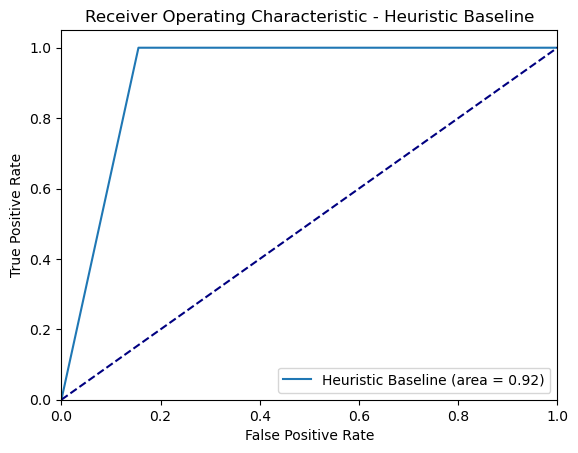

Heuristic Baseline - Accuracy: 0.8505791505791506
Heuristic Baseline - F1 Score: 0.3384615384615385
Heuristic Baseline - Precision: 0.2037037037037037
Heuristic Baseline - Recall: 1.0
Heuristic Baseline - ROC-AUC: 0.9223203532717784


In [51]:
# Set MLflow experiment
mlflow.set_experiment("Spotify Top 100 Prediction Exploration - 2")

# Heuristic Approach Logging
with mlflow.start_run(run_name="Heuristic Baseline"):
    # Analyze artist_popularity
    popularity_threshold = train_set[train_set['isTop100'] == 1]['artist_popularity'].median()
    print(f"Determined popularity threshold: {popularity_threshold}")

    # Analyze album_release_date
    latest_date_threshold = train_set[train_set['isTop100'] == 1]['album_release_date'].quantile(0.75)
    print(f"Determined album release date threshold (75th percentile): {pd.to_datetime(latest_date_threshold, unit='D', origin='1970-01-01')}")

    # Simple heuristic function to predict Top 100 status
    def heuristic_prediction(row, popularity_threshold, latest_date_threshold):
        if row['artist_popularity'] > popularity_threshold:
            return 1
        if row['album_release_date'] >= latest_date_threshold:
            return 1
        return 0

    # Apply heuristic to the test set
    test_set['heuristic_prediction'] = test_set.apply(
        heuristic_prediction,
        axis=1,
        popularity_threshold=popularity_threshold,
        latest_date_threshold=latest_date_threshold
    )
    
    # Evaluate heuristic approach
    heuristic_accuracy = accuracy_score(test_set['isTop100'], test_set['heuristic_prediction'])
    heuristic_f1 = f1_score(test_set['isTop100'], test_set['heuristic_prediction'])
    heuristic_precision = precision_score(test_set['isTop100'], test_set['heuristic_prediction'])
    heuristic_recall = recall_score(test_set['isTop100'], test_set['heuristic_prediction'])
    heuristic_roc_auc = roc_auc_score(test_set['isTop100'], test_set['heuristic_prediction'])

    # Calculate ROC curve
    heuristic_fpr, heuristic_tpr, _ = roc_curve(test_set['isTop100'], test_set['heuristic_prediction'])

    # Log metrics
    mlflow.log_metric("accuracy", heuristic_accuracy)
    mlflow.log_metric("f1_score", heuristic_f1)
    mlflow.log_metric("precision", heuristic_precision)
    mlflow.log_metric("recall", heuristic_recall)
    mlflow.log_metric("roc_auc", heuristic_roc_auc)

    # Plot ROC curve
    plt.figure()
    plt.plot(heuristic_fpr, heuristic_tpr, label=f'Heuristic Baseline (area = {heuristic_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Heuristic Baseline')
    plt.legend(loc='lower right')
    plt.show()

    # Remove heuristic_prediction column after logging metrics
    test_set.drop(columns=['heuristic_prediction'], inplace=True)

    # Print the metrics
    print(f"Heuristic Baseline - Accuracy: {heuristic_accuracy}")
    print(f"Heuristic Baseline - F1 Score: {heuristic_f1}")
    print(f"Heuristic Baseline - Precision: {heuristic_precision}")
    print(f"Heuristic Baseline - Recall: {heuristic_recall}")
    print(f"Heuristic Baseline - ROC-AUC: {heuristic_roc_auc}")

Results
The heuristic approach provided the following metrics:

- Accuracy: 0.851
- F1 Score: 0.338
- Precision: 0.204
- Recall: 1.0
- ROC-AUC: 0.922


The high recall value indicates that the heuristic approach is very effective at identifying songs that will be in the Top 100, although it also results in a lower precision, meaning that it also predicts a higher number of false positives. The ROC-AUC score suggests that the model performs well overall in distinguishing between Top 100 and non-Top 100 songs.


## 7 Model Training and Evaluation
In this section, we will experiment with various machine learning models to identify the best one for predicting whether a song will be in the Spotify Top 100. The models chosen for this project include `Logistic Regression`, `Random Forest`, `XGBoost`, `Support Vector Machine (SVM)`, `Gradient Boosting`, and an `Ensemble Voting Classifier`.

We will use `GridSearchCV` to perform hyperparameter tuning and MLflow to log and compare the performance of these models.


### 7.1 Model Selection
We have selected a diverse set of models for this project, each offering unique advantages:

- `Logistic Regression`: A simple yet effective linear model that is easy to interpret. It works well for binary classification tasks and can serve as a strong baseline.
- `Random Forest`: An ensemble learning method that combines multiple decision trees to improve the model's accuracy and robustness. It is known for its ability to handle a large number of features and prevent overfitting.
- `XGBoost`: A powerful gradient boosting algorithm that is highly efficient and scalable. It is often used in winning solutions for structured or tabular data.
- `SVM`: Support Vector Machine is effective in high-dimensional spaces and is often used for classification tasks with clear margin separation.
- `Gradient Boosting`: Another ensemble method that builds models sequentially, with each new model correcting the errors of the previous ones. It is known for its accuracy and flexibility.
- `Ensemble Voting Classifier`: Combines predictions from multiple models (Logistic Regression, Random Forest, XGBoost, SVM) to improve the overall performance. It uses a soft voting approach, considering the probability outputs of the individual models.

By experimenting with these models, we aim to leverage their strengths and identify the best-performing model for our task.


In [53]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Ensemble Voting': VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ], voting='soft')
}


### 7.2 Model Training  and Hyperparameter Tuning
GridSearchCV is used to perform hyperparameter tuning to find the best parameters for each model. This step involves training the models on the resampled training set.

In [55]:
# Define hyperparameters for GridSearchCV
param_grids = {
 'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Ensemble Voting': {
        'rf__n_estimators': [100],
        'rf__max_depth': [5, 7],
        'xgb__n_estimators': [100],
        'xgb__max_depth': [5, 7],
        'svc__C': [1],
        'svc__kernel': ['linear']
    }
}

# Iterate over models
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(train_set_selected[selected_features], train_set_selected['isTop100'])
    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"{model_name} - Best parameters: {grid_search.best_params_}")

Training Logistic Regression...
Logistic Regression - Best parameters: {'C': 0.1}
Training Random Forest...
Random Forest - Best parameters: {'max_depth': 7, 'n_estimators': 50}
Training XGBoost...
XGBoost - Best parameters: {'max_depth': 5, 'n_estimators': 200}
Training SVM...
SVM - Best parameters: {'C': 10, 'kernel': 'rbf'}
Training Gradient Boosting...
Gradient Boosting - Best parameters: {'max_depth': 5, 'n_estimators': 200}
Training Ensemble Voting...
Ensemble Voting - Best parameters: {'rf__max_depth': 7, 'rf__n_estimators': 100, 'svc__C': 1, 'svc__kernel': 'linear', 'xgb__max_depth': 7, 'xgb__n_estimators': 100}


### 7.3 Model Evaluation
To evaluate the models, we captured metrics such as accuracy, F1 score, precision, recall, and ROC-AUC using MLflow. These metrics provide a comprehensive view of the model's performance. 
Given the nature of this project, we will focus more on the F1 score and ROC-AUC, as they provide a balance between precision and recall and offer a comprehensive performance measure across all classification thresholds.

Metrics Explanation:

- `Accuracy`: Proportion of true results (both true positives and true negatives) among the total number of cases examined. Useful when classes are balanced.
- `F1 Score`: Harmonic mean of precision and recall, providing a balance between the two. Particularly useful when the class distribution is imbalanced.
- `Precision`: Ratio of correctly predicted positive observations to the total predicted positives. Indicates the accuracy of the positive predictions.
- `Recall (Sensitivity`): Ratio of correctly predicted positive observations to all the observations in the actual class. Measures the model's ability to identify all relevant instances.
- `ROC-AUC`: Area under the Receiver Operating Characteristic curve, which plots the true positive rate (recall) against the false positive rate. Provides an aggregate measure of performance across all classification thresholds.


We will capture these metrics using MLflow to compare the models and select the best one for deployment.

Logistic Regression - Accuracy: 0.7945945945945946
Logistic Regression - F1 Score: 0.2569832402234637
Logistic Regression - Precision: 0.14910858995137763
Logistic Regression - Recall: 0.9292929292929293
Logistic Regression - ROC-AUC: 0.9111832901475615


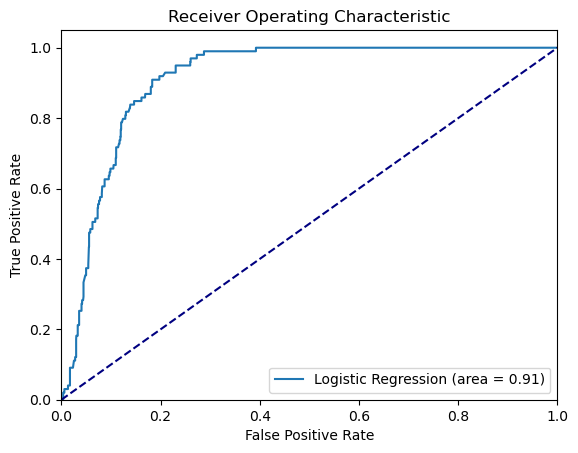

Random Forest - Accuracy: 0.9544401544401544
Random Forest - F1 Score: 0.5845070422535211
Random Forest - Precision: 0.4486486486486487
Random Forest - Recall: 0.8383838383838383
Random Forest - ROC-AUC: 0.9814118706129947


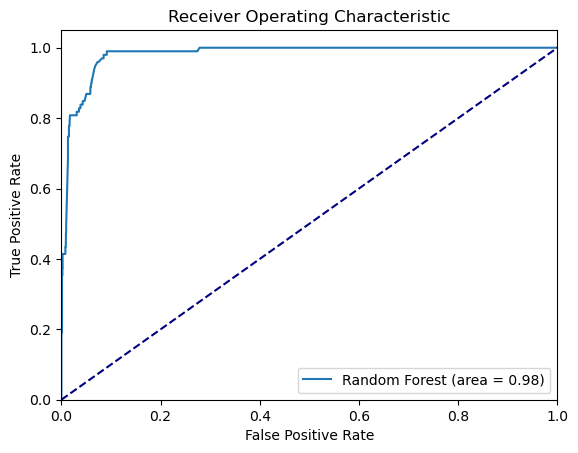

XGBoost - Accuracy: 0.9845559845559846
XGBoost - F1 Score: 0.8058252427184466
XGBoost - Precision: 0.7757009345794392
XGBoost - Recall: 0.8383838383838383
XGBoost - ROC-AUC: 0.9924739161993277


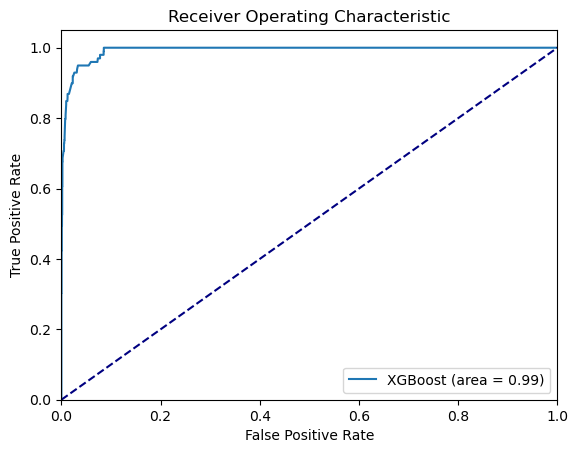

SVM - Accuracy: 0.8142857142857143
SVM - F1 Score: 0.28101644245142005
SVM - Precision: 0.1649122807017544
SVM - Recall: 0.9494949494949495
SVM - ROC-AUC: 0.9281129236970265


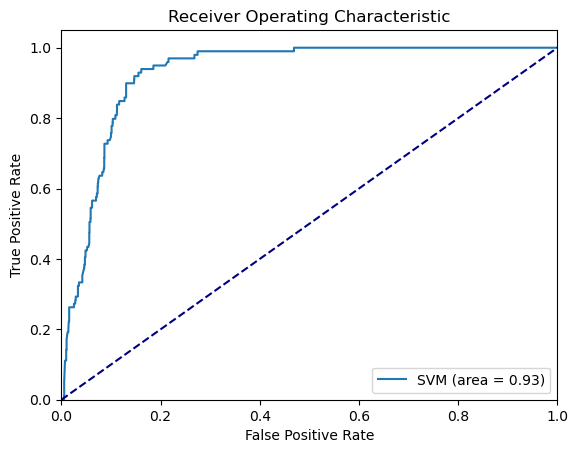

Gradient Boosting - Accuracy: 0.983011583011583
Gradient Boosting - F1 Score: 0.7843137254901961
Gradient Boosting - Precision: 0.7619047619047619
Gradient Boosting - Recall: 0.8080808080808081
Gradient Boosting - ROC-AUC: 0.9933457416395995


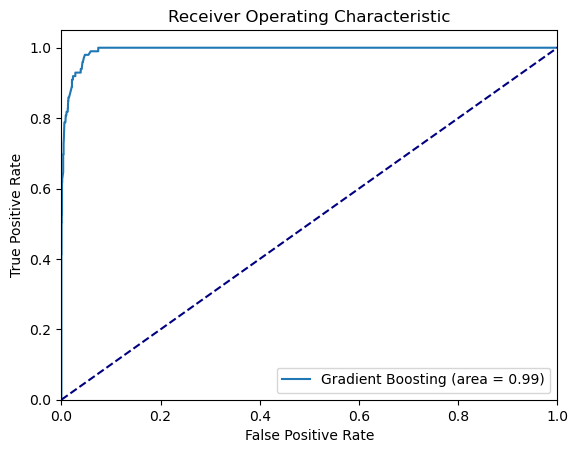

Ensemble Voting - Accuracy: 0.974903474903475
Ensemble Voting - F1 Score: 0.723404255319149
Ensemble Voting - Precision: 0.625
Ensemble Voting - Recall: 0.8585858585858586
Ensemble Voting - ROC-AUC: 0.9865455032054792


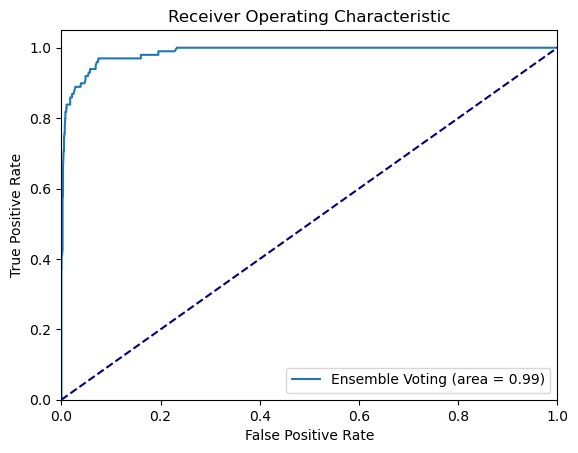

In [56]:
# Iterate over the trained models and log metrics
for model_name, model in best_models.items():
    with mlflow.start_run(run_name=model_name):
        # Predict on the test set
        predictions = model.predict(test_set_selected[selected_features])
        probabilities = model.predict_proba(test_set_selected[selected_features])[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(test_set_selected['isTop100'], predictions)
        f1 = f1_score(test_set_selected['isTop100'], predictions)
        precision = precision_score(test_set_selected['isTop100'], predictions)
        recall = recall_score(test_set_selected['isTop100'], predictions)
        roc_auc = roc_auc_score(test_set_selected['isTop100'], probabilities)
        
        fpr, tpr, _ = roc_curve(test_set_selected['isTop100'], probabilities)
        
        # Log parameters
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Prepare an input example for model logging
        input_example = test_set_selected[selected_features].head(1)
        
        # Log the model with the input example
        mlflow.sklearn.log_model(model, "model", input_example=input_example)
        
        # Print the metrics
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - F1 Score: {f1}")
        print(f"{model_name} - Precision: {precision}")
        print(f"{model_name} - Recall: {recall}")
        print(f"{model_name} - ROC-AUC: {roc_auc}")
        
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

## 8 Model Deployment

### 8.1 Saving Model Components
To ensure our model can be deployed and used for predictions, we save the essential components required for preprocessing and transforming new data points. These components include the `top 100 genres`, `scalers`, and `PCA model`.



In [53]:
import joblib

# Save the top 100 genres, scalers, PCA, and other models
joblib.dump(top_100_train_genres, 'top_100_genres.pkl')
joblib.dump(scaler_loudness, 'scaler_loudness.pkl')
joblib.dump(scaler, 'scaler_genres.pkl')
joblib.dump(pca, 'pca.pkl')


['pca.pkl']

### 8.2 Using the Model Generated by MLflow
For the actual model, we will use the one generated and tracked by MLflow. MLflow helps in 
managing the lifecycle of the machine learning model, including experimentation, reproducibility, and deployment.

Instead of using the Random Forest selector model, we will directly call the selected features for predictions. This approach ensures we use the model's parameters and structure as stored in MLflow, facilitating better model management and consistency.

In this notebook, we developed a machine learning model to predict the success of songs on Spotify. We went through the steps of data collection, preprocessing, model training, and evaluation. Finally, we discussed the deployment of the model, including saving the model and setting up an API for predictions. Through various experiments, we tuned our model to achieve the best performance, providing valuable insights for music labels and producers.


In [ ]:
!mlflow ui --host 0.0.0.0 --port 5001

[2024-08-11 11:58:22 +0800] [37354] [INFO] Starting gunicorn 22.0.0
[2024-08-11 11:58:22 +0800] [37354] [INFO] Listening at: http://0.0.0.0:5001 (37354)
[2024-08-11 11:58:22 +0800] [37354] [INFO] Using worker: sync
[2024-08-11 11:58:22 +0800] [37355] [INFO] Booting worker with pid: 37355
[2024-08-11 11:58:22 +0800] [37356] [INFO] Booting worker with pid: 37356
[2024-08-11 11:58:22 +0800] [37357] [INFO] Booting worker with pid: 37357
[2024-08-11 11:58:22 +0800] [37358] [INFO] Booting worker with pid: 37358
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
# from pyngrok import ngrok
# ngrok.kill()

# # Setting the auth token (optional)
# NGROK_AUTH_TOKEN = ""  # Replace with your actual Ngrok auth token if you have one
# if NGROK_AUTH_TOKEN:
#     ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Open HTTPS tunnel on port 5000 for http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
# print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# Start MLflow UI (if MLflow is installed and running)
# !mlflow ui